This notebook focuses on analysing the Seattle AirBnB dataset available from [Kaggle](https://www.kaggle.com/airbnb/seattle/data). This notebook was done as a project for the Data Scientist Nanodegree program on Udacity.

# Package import ad paths setup

In [ ]:
!pip install missingno

In [ ]:
!pip install xgboost

In [ ]:
!pip install shap

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import missingno
import seaborn as sns
from functools import reduce

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import shap

In [6]:
%matplotlib inline

In [10]:
DATA_FOLDER = Path('data')

In [11]:
!ls $DATA_FOLDER

calendar.csv
listings.csv
reviews.csv


In [12]:
calendar = pd.read_csv(DATA_FOLDER / 'calendar.csv')
listings = pd.read_csv(DATA_FOLDER / 'listings.csv')
reviews = pd.read_csv(DATA_FOLDER / 'reviews.csv')

In [13]:
pd.set_option('display.max_rows', None)

# Data quality

In this first section we will look into the quality of the data. Specifically we will look at missing values in the data. I like to use the package [missingno](https://github.com/ResidentMario/missingno), which gives a good overview of columns and where there are missing values.

## Calendar data

In [15]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [16]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


From the info above, we have some columns that need cleaning and type conversion. The date column needs to be converted to a datetime type and the price column needs to be cleaned and converted into a float type.

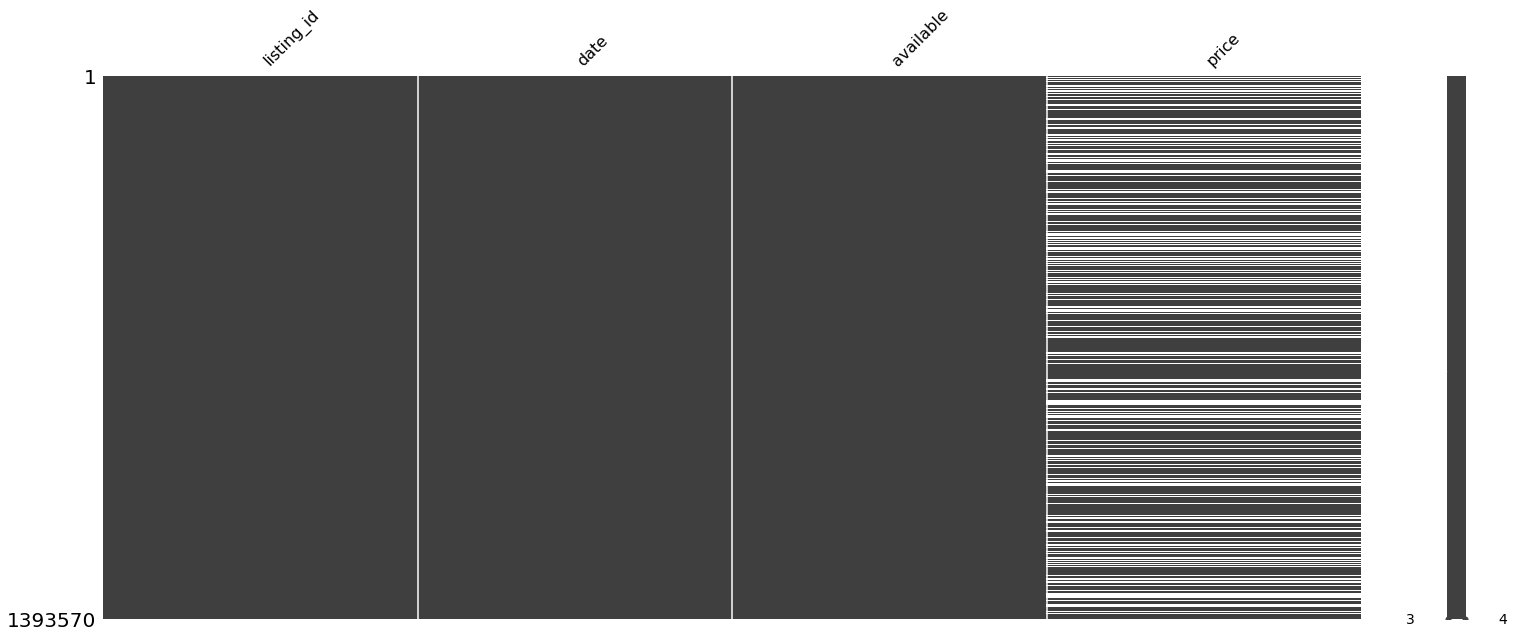

In [17]:
missingno.matrix(calendar);

This data shows what prices listings have had at a given time. Also it shows if the listing has been rented out or not.

Apparent from above is that the price column often has null values. Seing as the data lists prices and availability given a certain date, it is possible that this is a natural thing, since listings will be shown without prices, whenever they are rented out to visitors. We can investigate this by filtering all rows where `available == 'f'` and counting number of unique values

In [18]:
calendar[calendar['available'] == 'f']['price'].value_counts()

Series([], Name: price, dtype: int64)

Indeed for all rows where the listing is not available, price will be a NaN. We can also investigate if there are any rows with available listings where the price is NaN

In [19]:
calendar_nans = calendar[calendar.isna().any(axis=1)]

In [20]:
len(calendar_nans[calendar_nans['available'] == 't'])

0

This shows that the data is clean and we have a price for every row where a listing is available.

In [21]:
print(f'Number of rows in calendar data: {len(calendar)}')

Number of rows in calendar data: 1393570


### Cleaning

In [22]:
def clean_calendar(calendar):
    """
    Calendar dataset cleaner.
    
    Cleans the calendar dataset.
    
    Parameters:
    calendar (Dataframe): Dataframe containing calendar data, where data has not been cleaned.
    
    Returns:
    Dataframe: Calendar data that has been cleaned.
    """
    calendar_clean = calendar.copy()
    
    # Converting the date to a pandas datetime type
    calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
    
    # Removing calendar entries from when the properties are rented out
    #calendar_clean = calendar_clean[calendar_clean['available'] == 't']
    
    # Converting price to a float value
    calendar_clean['cleaned_price'] = calendar_clean['price'].str.replace('[$,]','').astype('float')
    
    return calendar_clean

In [23]:
calendar_clean = clean_calendar(calendar)

## Listings data

In [24]:
# Allow printing of more rows, so we can see content of all columns in listings dataframe.
pd.options.display.max_rows = len(listings.columns)

In [25]:
listings.sample(10).T

,3628,3602,2762,2997,1075,2021,1058,2748,2617,3485
id,6637899,8845144,8116395,2158992,5422159,4863533,7048843,2004931,3594885,6765354
listing_url,https://www.airbnb.com/rooms/6637899,https://www.airbnb.com/rooms/8845144,https://www.airbnb.com/rooms/8116395,https://www.airbnb.com/rooms/2158992,https://www.airbnb.com/rooms/5422159,https://www.airbnb.com/rooms/4863533,https://www.airbnb.com/rooms/7048843,https://www.airbnb.com/rooms/2004931,https://www.airbnb.com/rooms/3594885,https://www.airbnb.com/rooms/6765354
scrape_id,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432
last_scraped,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04
name,Sweet Dreams Capitol Hill,Ultra Cozy Room in Highly-Rated BnB,Entire apartment in Capitol Hill,Lovely home in Ballard neighborhood,Luxurious Seattle Apartment,Artists' off Greenwood 2 Bedroom,"Large Room, 2-mile to downtown",Lux 1BD in CapHill. 97 Walkscore,1BR in Capitol Hill. 97 Walk Score!,Roadhouse Retreat
summary,Extra large bedroom with 6 windows--so much li...,"The Foxglove Guesthouse, an intimate bed and b...",1 bedroom apartment located in the best of bot...,"This home is a perfect place to relax, make di...",Visiting Seattle? You have found a home. With ...,"Cozy, updated apt one block off Greenwood Ave....",House is 2 miles from city center. Private la...,97 Walkscore!! Our favorite area in cap hill w...,This beautiful contemporary 1 bedroom apartmen...,This former Roadhouse has a ton of historic ch...
space,Lovely street with views to Lake Washington an...,"The Foxglove Guesthouse, an intimate bed and b...",The apartment is yours to do what one would do...,"This home is a quick walk to restaurants, bars...",Spacious studio in downtown Seattle(1st Avenue...,"Our home is kid friendly, art friendly, queer ...",House is two-level. Your room is private with...,Our favorite area in cap hill with everything ...,NaN,Stay in artsy historic Georgetown. This is a ...
description,Extra large bedroom with 6 windows--so much li...,"The Foxglove Guesthouse, an intimate bed and b...",1 bedroom apartment located in the best of bot...,"This home is a perfect place to relax, make di...",Visiting Seattle? You have found a home. With ...,"Cozy, updated apt one block off Greenwood Ave....",House is 2 miles from city center. Private la...,97 Walkscore!! Our favorite area in cap hill w...,This beautiful contemporary 1 bedroom apartmen...,This former Roadhouse has a ton of historic ch...
experiences_offered,none,none,none,none,none,none,none,none,none,none
neighborhood_overview,Located on the east slope of Capitol HIll with...,Capitol Hill is really the best neighborhood t...,Capitol Hill is the place to experience Seattl...,Ballard is the best neighborhood in Seattle! F...,"Walking distance to Pike Place market, Seattle...","Greenwood features many well loved bars, pubs ...","Next to park, jogging and biking trail.",NaN,NaN,Georgetown is located between downtown Seattle...


In [26]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

A few columns need to be cleaned and converted to right type.

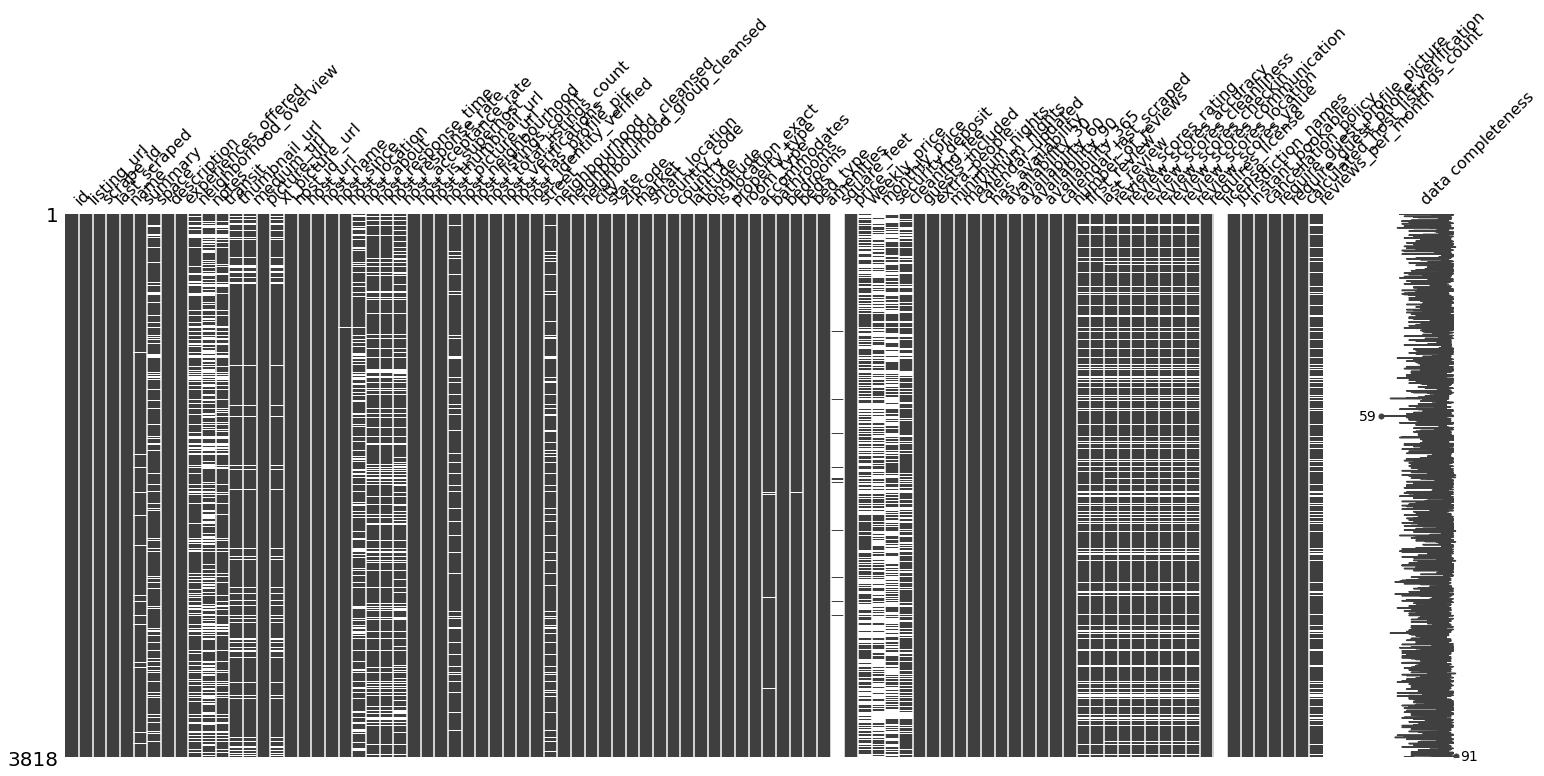

In [27]:
missingno.matrix(listings, labels=True);

This data describes each of the listings on AirBnB. There are a total of 91 columns and a lot of them have missing values at various places. 

The row with the minium missing values still has 59 values missing, and the row with the maximum values missing has 91 values missing. 

There are good reasons for listing data to have missing values since listings are of various types, also the owner might not have completed the many ways in which there is to describe the listing.

In [28]:
print(f'Number of rows in listings: {len(listings)}')

Number of rows in listings: 3818


### Cleaning

In [29]:
def clean_listings(listings):
    """
    Listings dataset cleaner.
    
    Cleans the listings dataset.
    
    Parameters:
    listings (Dataframe): Dataframe containing listings data, where data has not been cleaned.
    
    Returns:
    Dataframe: Listings data that has been cleaned.
    """
    listings_clean = listings.copy()

    # Converting percentage strings into floats
    listings_clean['host_response_rate'] = listings_clean['host_response_rate'].str.replace('%','').astype('float')
    listings_clean['host_acceptance_rate'] = listings_clean['host_acceptance_rate'].str.replace('%','').astype('float')
    
    # Converting price to a float value
    listings_clean['price'] = listings_clean['price'].str.replace('[$,]','').astype('float')
    listings_clean['weekly_price'] = listings_clean['weekly_price'].str.replace('[$,]','').astype('float')
    listings_clean['monthly_price'] = listings_clean['monthly_price'].str.replace('[$,]','').astype('float')
    listings_clean['security_deposit'] = listings_clean['security_deposit'].str.replace('[$,]','').astype('float')
    listings_clean['cleaning_fee'] = listings_clean['cleaning_fee'].str.replace('[$,]','').astype('float')
    listings_clean['extra_people'] = listings_clean['extra_people'].str.replace('[$,]','').astype('float')
    
    # Converting the date to a pandas datetime type
    listings_clean['last_scraped'] = pd.to_datetime(listings_clean['last_scraped'])
    listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'])
    listings_clean['calendar_last_scraped'] = pd.to_datetime(listings_clean['calendar_last_scraped'])
    listings_clean['first_review'] = pd.to_datetime(listings_clean['first_review'])
    listings_clean['last_review'] = pd.to_datetime(listings_clean['last_review'])
    
    return listings_clean

In [30]:
listings_clean = clean_listings(listings)

## Reviews

In [31]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


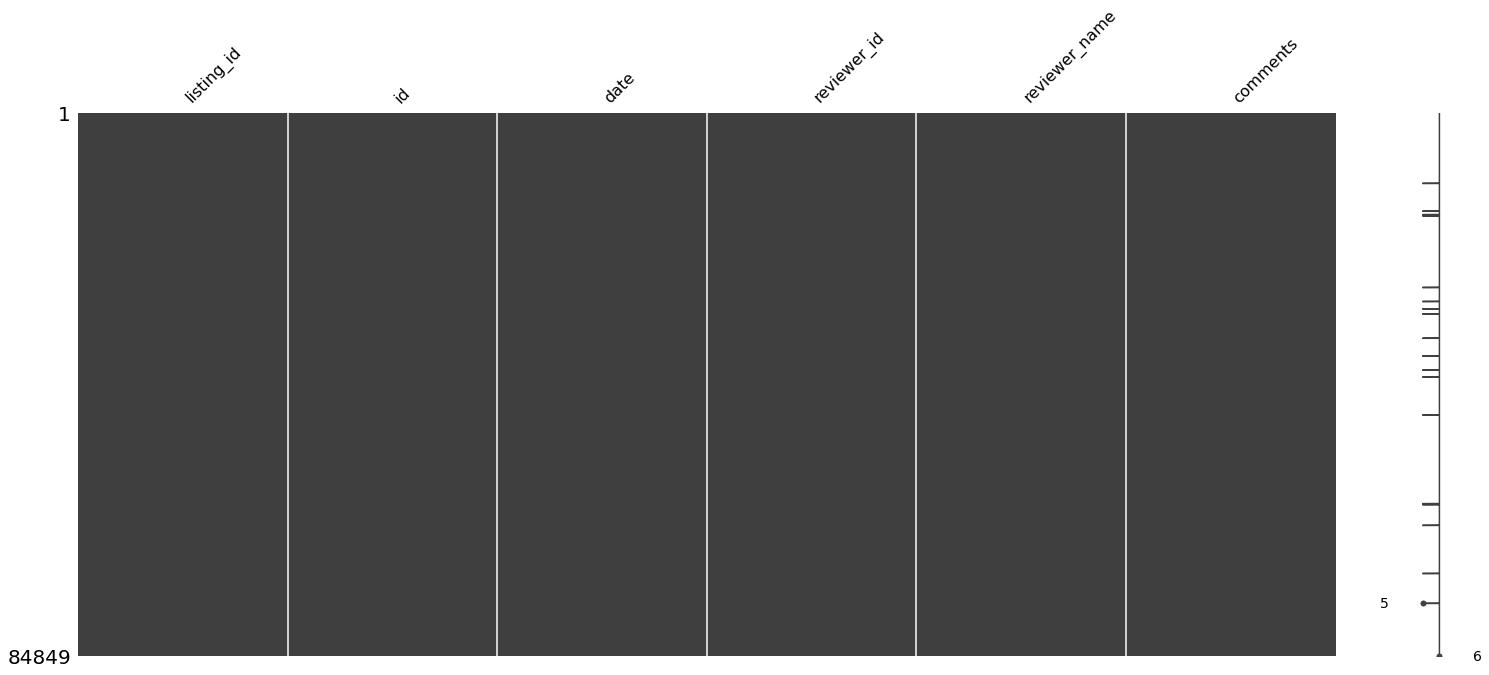

In [32]:
missingno.matrix(reviews)

This data shows the visitors reviews in text for a given listing, at a given date. Remarkably there are very few missing values.

In [33]:
print(f'Number of rows in reviews: {len(reviews)}')

Number of rows in reviews: 84849


# Business Understanding

Questions to answer with the data
- What is the yearly price trend?
- What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?
- Are there any property types that demand a higher price than others?
- How many consecutive days are properties usually rented out for?

# Q1: What is the yearly price trend

In [34]:
# We group by date and compute basic statistics
calendar_stats = (calendar_clean[calendar_clean['available'] == 't']
                  .groupby(['date'])
                  .agg({'cleaned_price':{'min','max','std','mean'}})
                 )
# Filter so that we look at a complete year
calendar_year = calendar_stats['2016-01-01':'2016-12-31']
# Resample on month basis and take the mean
calendar_month = calendar_stats.resample('M').mean()
# Get nice names for the months
calendar_month['month_names'] = calendar_month.index.strftime('%b')

Mean price: $137.66


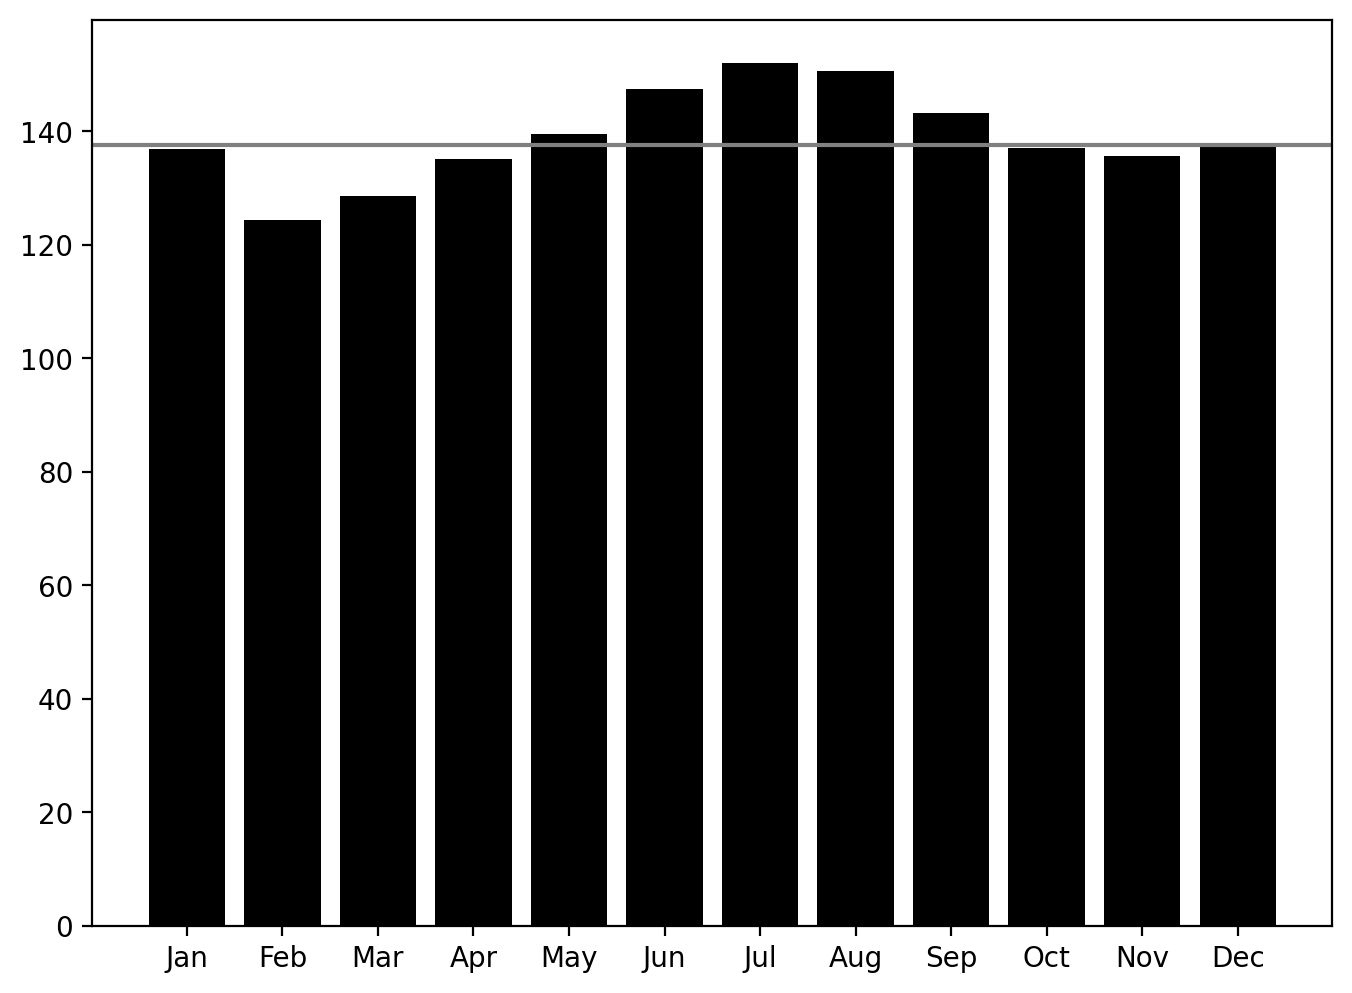

In [35]:
# Use matplotib to display barchart over mean prices per month
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
ax.bar(calendar_month['month_names'], calendar_month['cleaned_price']['mean'], color='k')
price_mean = calendar_month['cleaned_price']['mean'].mean()
ax.axhline(calendar_month['cleaned_price']['mean'].mean(), c='gray')
print(f'Mean price: ${round(price_mean,2)}')
ax.grid(False)
ax.set_ylim(0,None)
fig.savefig('images/yearly_trend.png', dpi=200);

In [36]:
# Show overview per month, also showing min, max and std
calendar_month

cleaned_price                                     month_names
                    mean        min         std          max            
date                                                                    
2016-01-31    121.692505  21.000000   86.837877   988.392857         Jan
2016-02-29    124.315614  20.689655   91.483902  1000.000000         Feb
2016-03-31    128.640797  20.000000   94.292904  1099.000000         Mar
2016-04-30    135.109460  20.000000   98.167124  1092.400000         Apr
2016-05-31    139.539566  20.000000  102.701959  1099.000000         May
2016-06-30    147.469191  20.000000  112.386836  1099.000000         Jun
2016-07-31    152.102977  20.000000  120.059787  1195.225806         Jul
2016-08-31    150.657032  20.000000  118.737648  1218.741935         Aug
2016-09-30    143.277182  20.000000  108.727341  1430.000000         Sep
2016-10-31    137.033871  20.000000  104.442009  1643.548387         Oct
2016-11-30    135.687825  19.666667  104.219171  1650.000000         Nov
2016-12-31    137.238611  20.000000  105.002975  1650.000000         Dec
2017-01-31    136.849867  20.000000  104.647242  1000.000000         Jan

From above the average price doesn't vary much over the year.

# Q2: What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?

In [37]:
# Merge calendar data that contain prices with listing data filtered down to neighborhood
neighbourhood_price = listings_clean[['id', 'neighbourhood_cleansed']].merge(calendar_clean, left_on='id', right_on='listing_id')

In [38]:
# Pivot so we get neighbourhood versus price
neighbourhood_pivot = neighbourhood_price.pivot(columns='neighbourhood_cleansed', values='cleaned_price')
neighbourhood_sort_index = neighbourhood_pivot.mean().sort_values(ascending=False).index

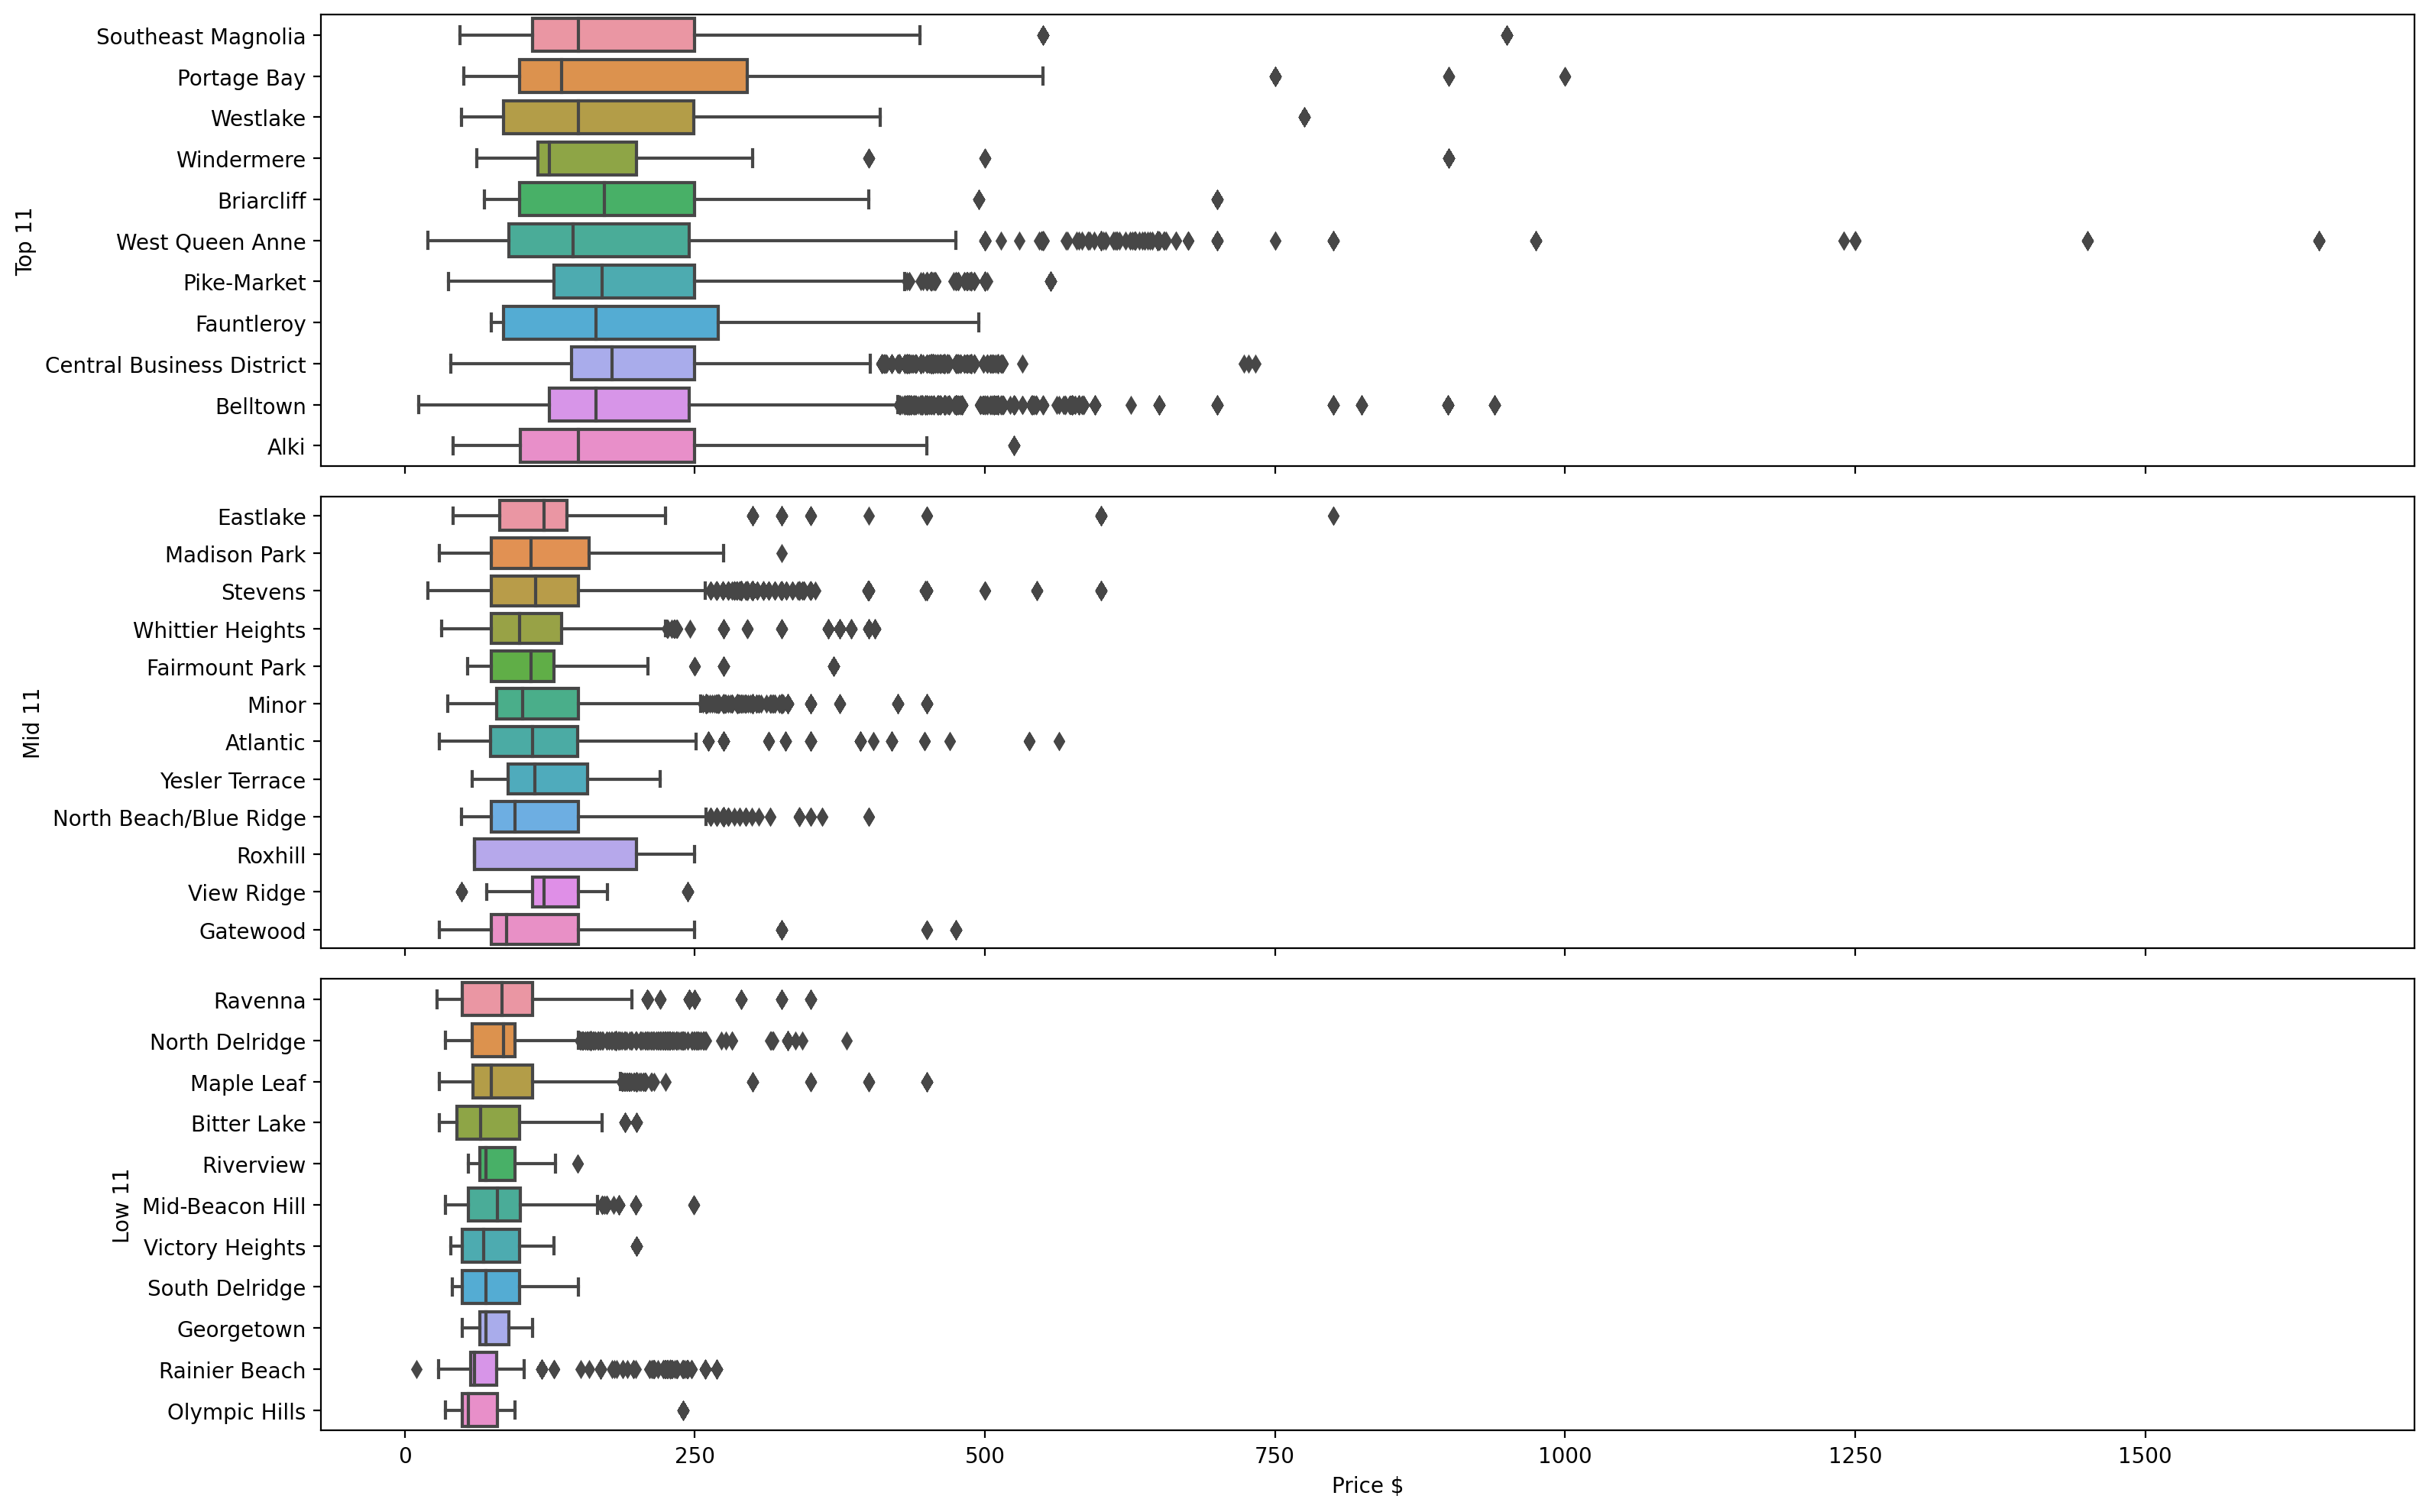

In [39]:
# Plot top, mid and bottom neighbourhoods when it comes to price
fig,ax = plt.subplots(3,1, figsize=(16,10), sharex=True, dpi=200)

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[:11]], orient='h', ax=ax[0])
ax[0].set_ylabel('Top 11')

midpoint = len(neighbourhood_sort_index)/2
sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[round(midpoint-5):round(midpoint+6)]], orient='h', ax=ax[1])
ax[1].set_ylabel('Mid 11')

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[-11:]], orient='h', ax=ax[2])
ax[2].set_ylabel('Low 11')
ax[2].set_xlabel('Price $')

fig.set_tight_layout(True)
fig.savefig('images/neighborhood_comparison.png', dpi=200);

# Q3: Property types vs price

In [40]:
# Merge calendar data with prices with listings data filtered down to property type
room_type_price = listings_clean[['id', 'property_type']].merge(calendar_clean, left_on='id', right_on='listing_id')
# Pivot so we have property type versus price
room_type_price_pivot = room_type_price.pivot(columns='property_type', values='cleaned_price')

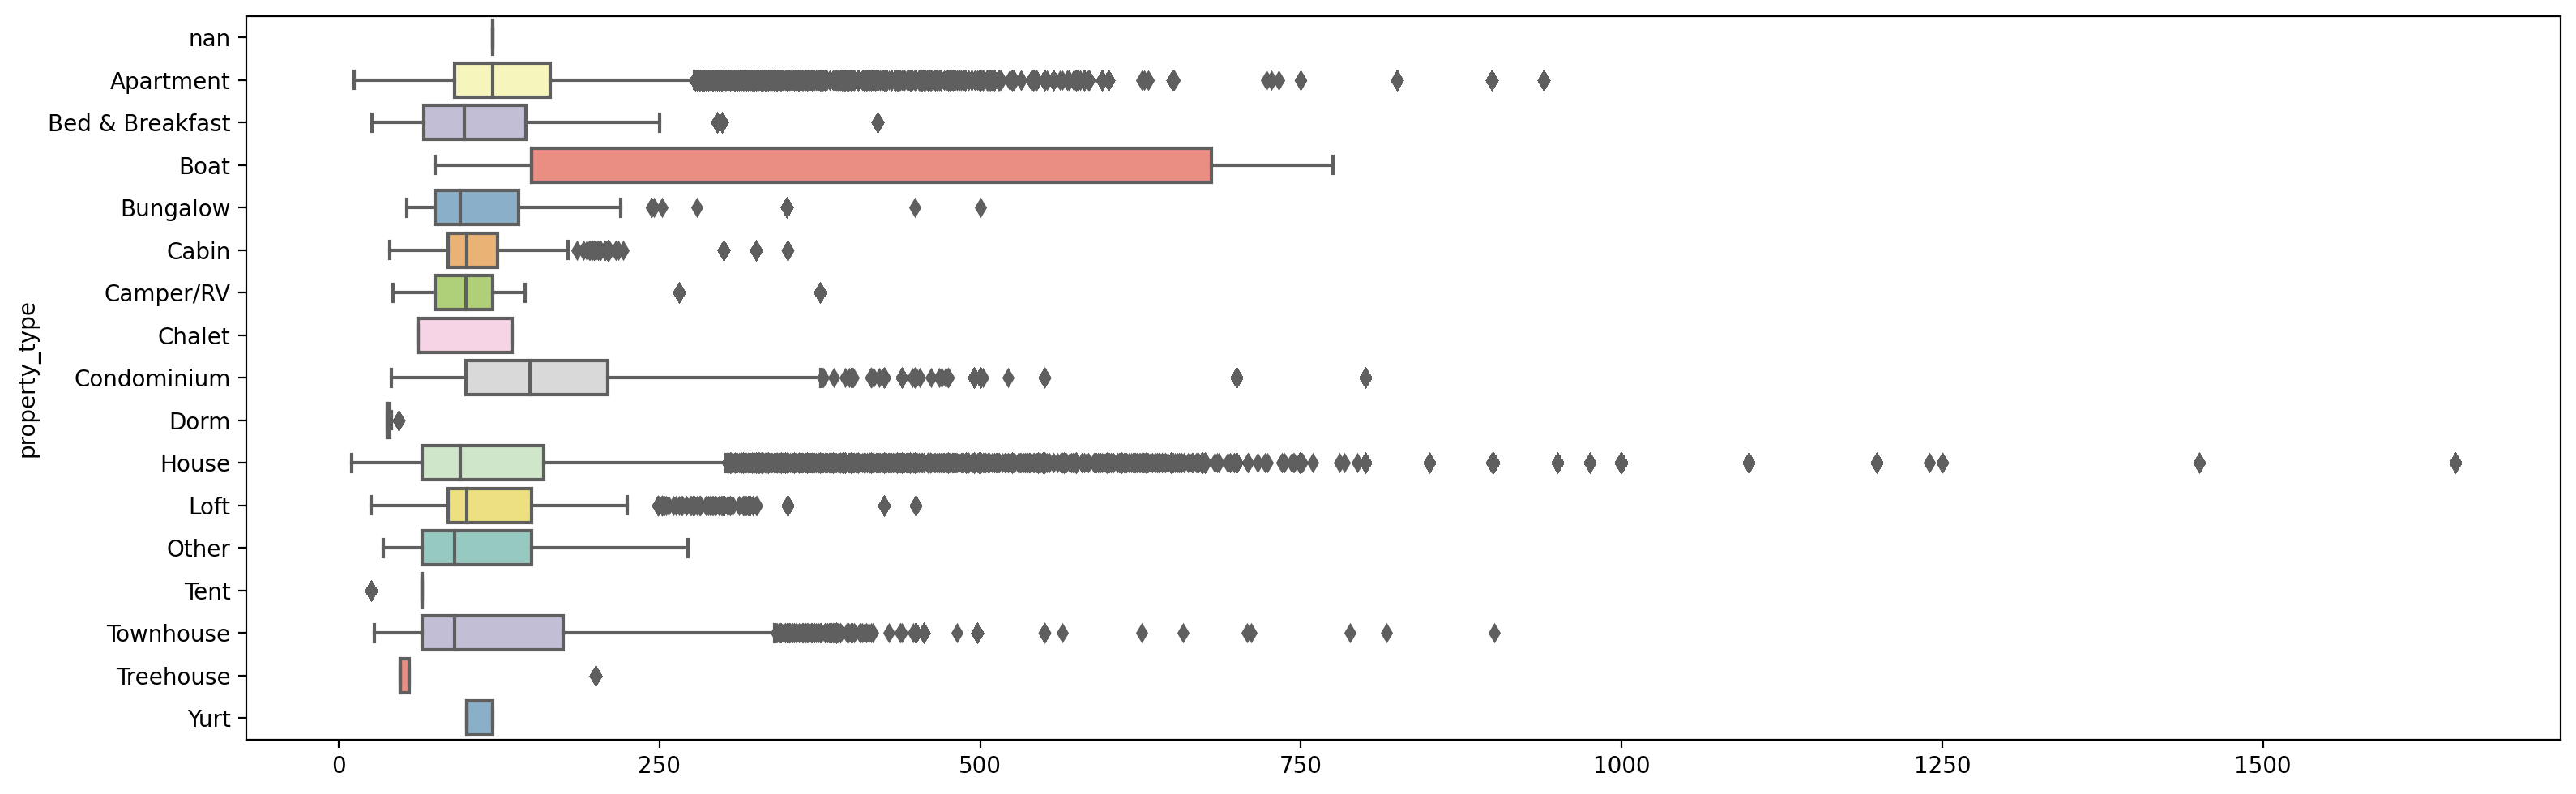

In [41]:
# Plot property type versus price
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.boxplot(data=room_type_price_pivot, orient='h', ax=ax, palette='Set3')
fig.set_tight_layout(True)
fig.savefig('images/property_type.png', dpi=200);

## Q4: Yearly availability trend

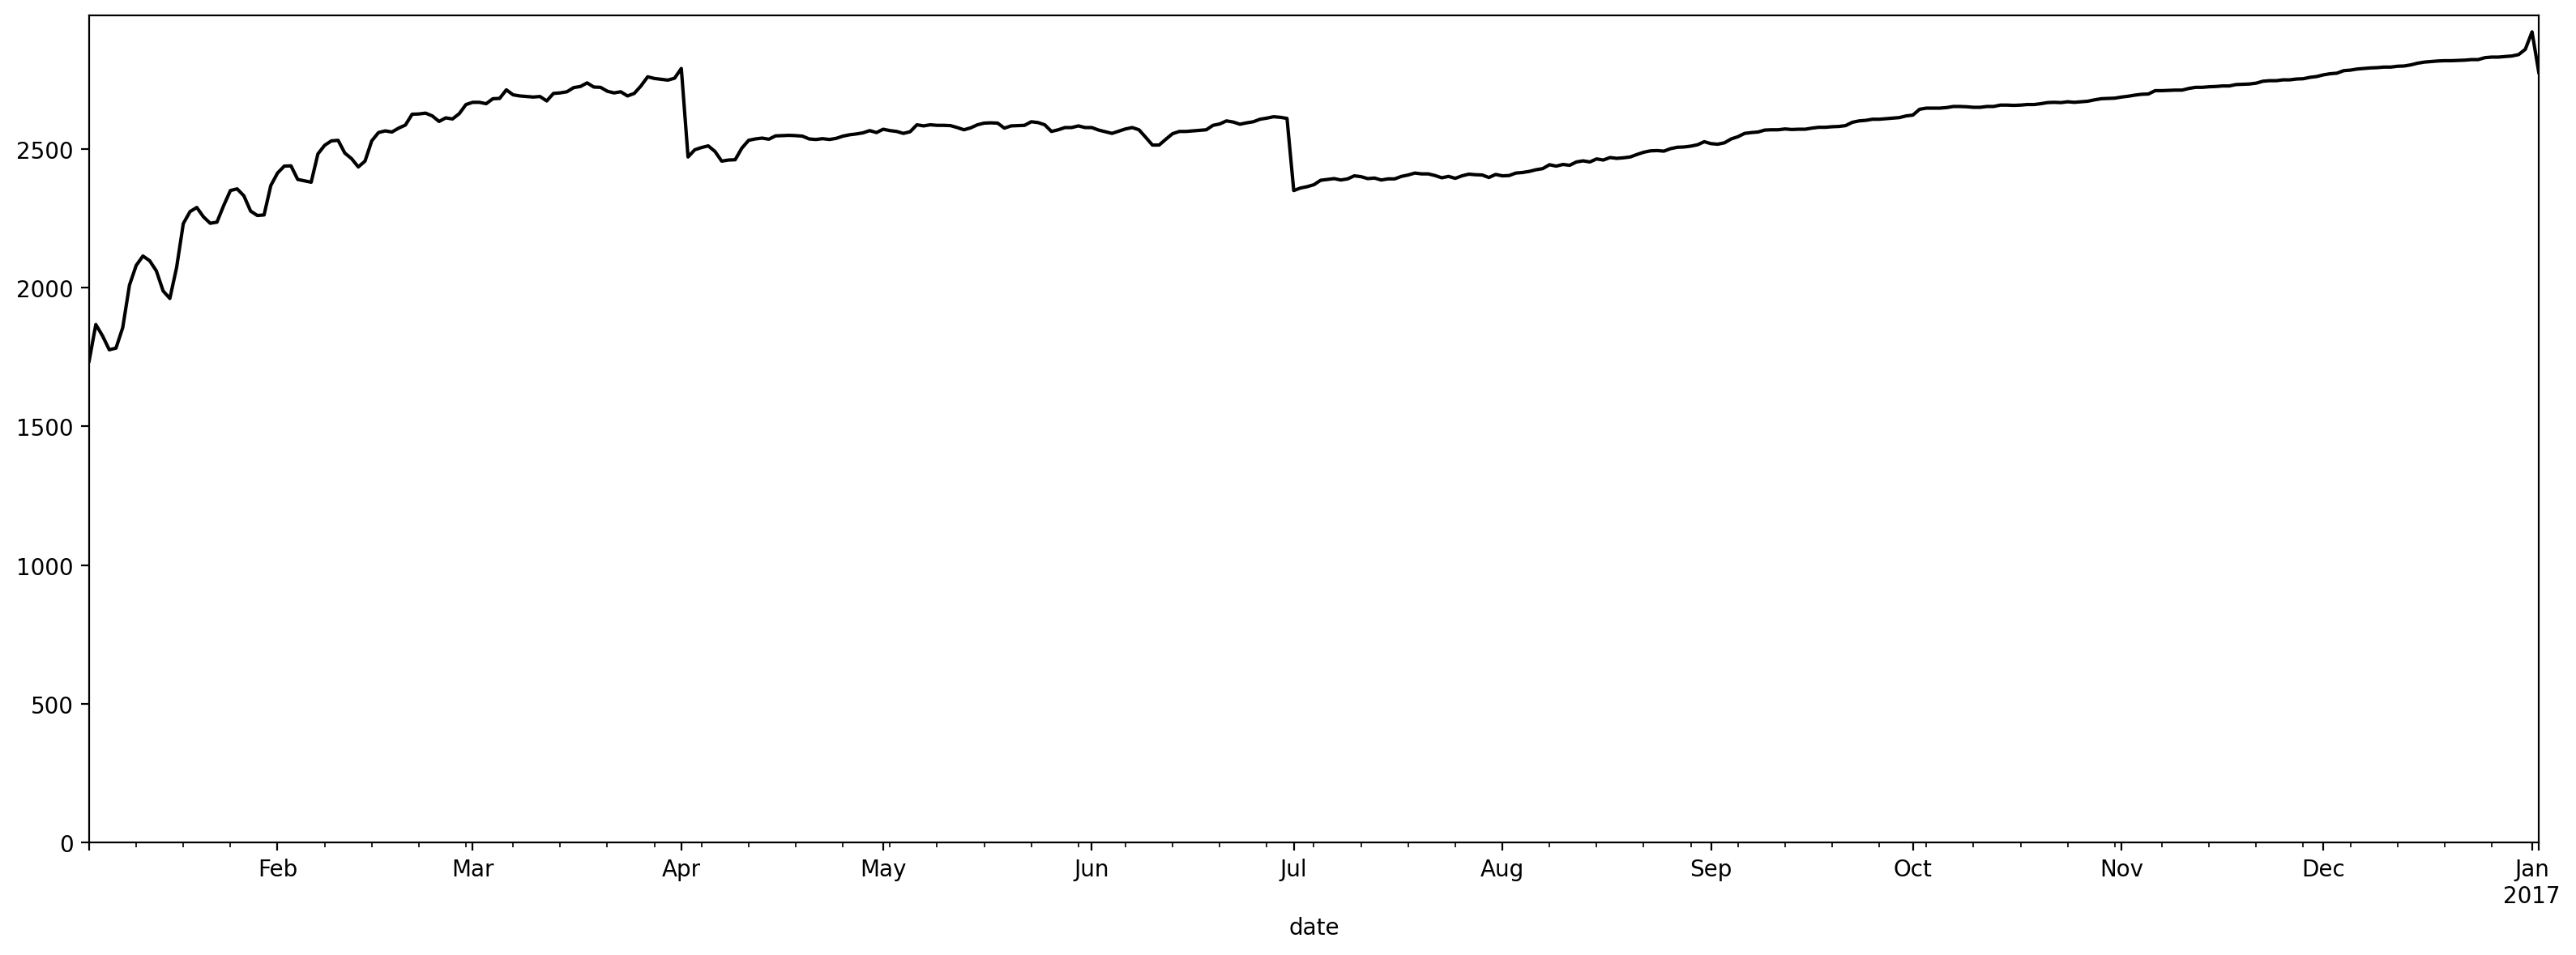

In [42]:
# Plot yearly availability
fig,ax = plt.subplots(figsize=(16,6), dpi=200)
calendar_clean[calendar_clean['available'] == 't'].groupby('date').size().plot(ax=ax, c='k')
ax.set_ylim(0,None)
fig.set_tight_layout(True)
fig.savefig('images/yearly_availability_trend.png', dpi=200);

The plot above shows the number of available listings for any given day of the year. Either there are some issues with the data or there are some very consistent trends. The sharp jumps at April and July signify that a lot of listings were either reserved or taken offline. 

## Q5: Consecutive rental days

In [43]:
# Calculate consecutive rentals, pivot calendar table for each listing versus date, using available as value
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
# Iterate through each listing in the columns
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    # Check each column for change in state, count each change in state as a new grouping
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    # Group by change in state and get amount of days in each state
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    # Make nicer columns for output
    dat.columns = ['availability', 'group', 'consecutive_days']
    dat['listing_id'] = col
    consec_days.append(dat)

# Concatenate all the individual listing consecutive rental day data into one dataframe
consecutive_rental_days_listing = pd.concat(consec_days, axis=0)

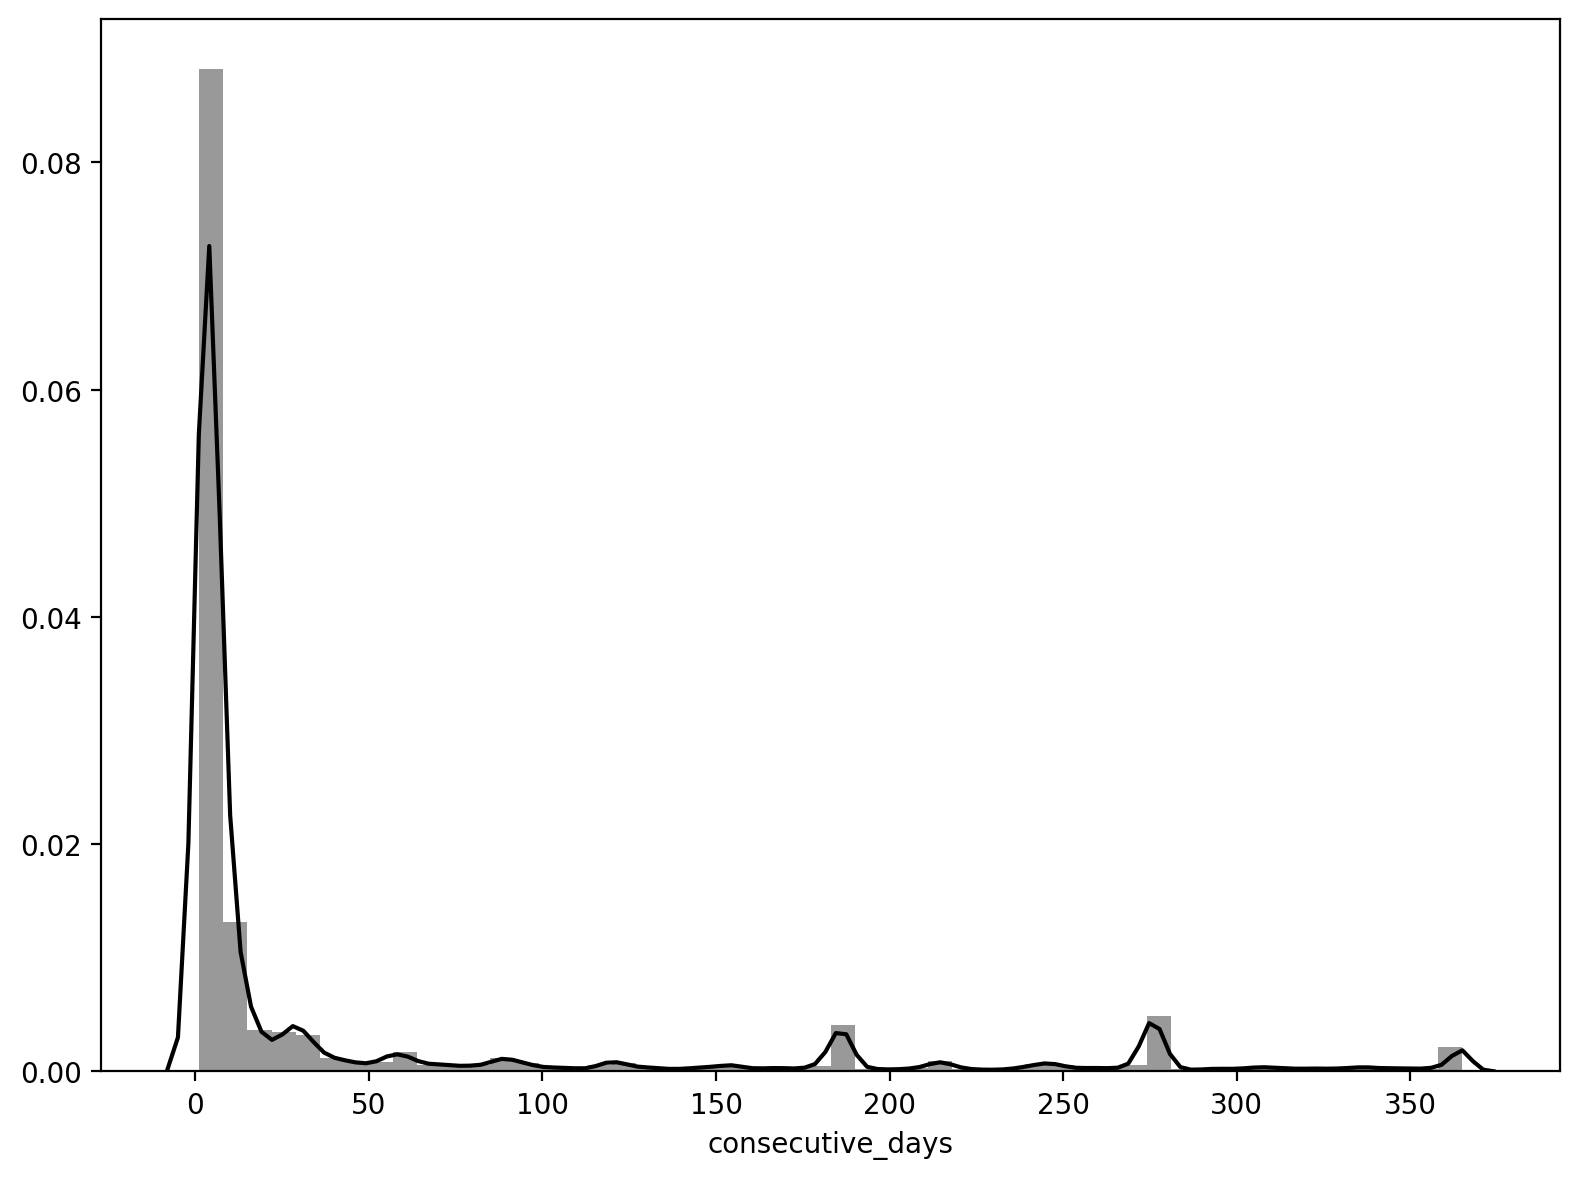

In [44]:
# Plot consecutive rental day data
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']['consecutive_days']
sns.distplot(consecutive_rented_days, bins=52, color='k')
ax.set_yscale('linear')
fig.set_tight_layout(True)
fig.savefig('images/consecutive.png', dpi=200);

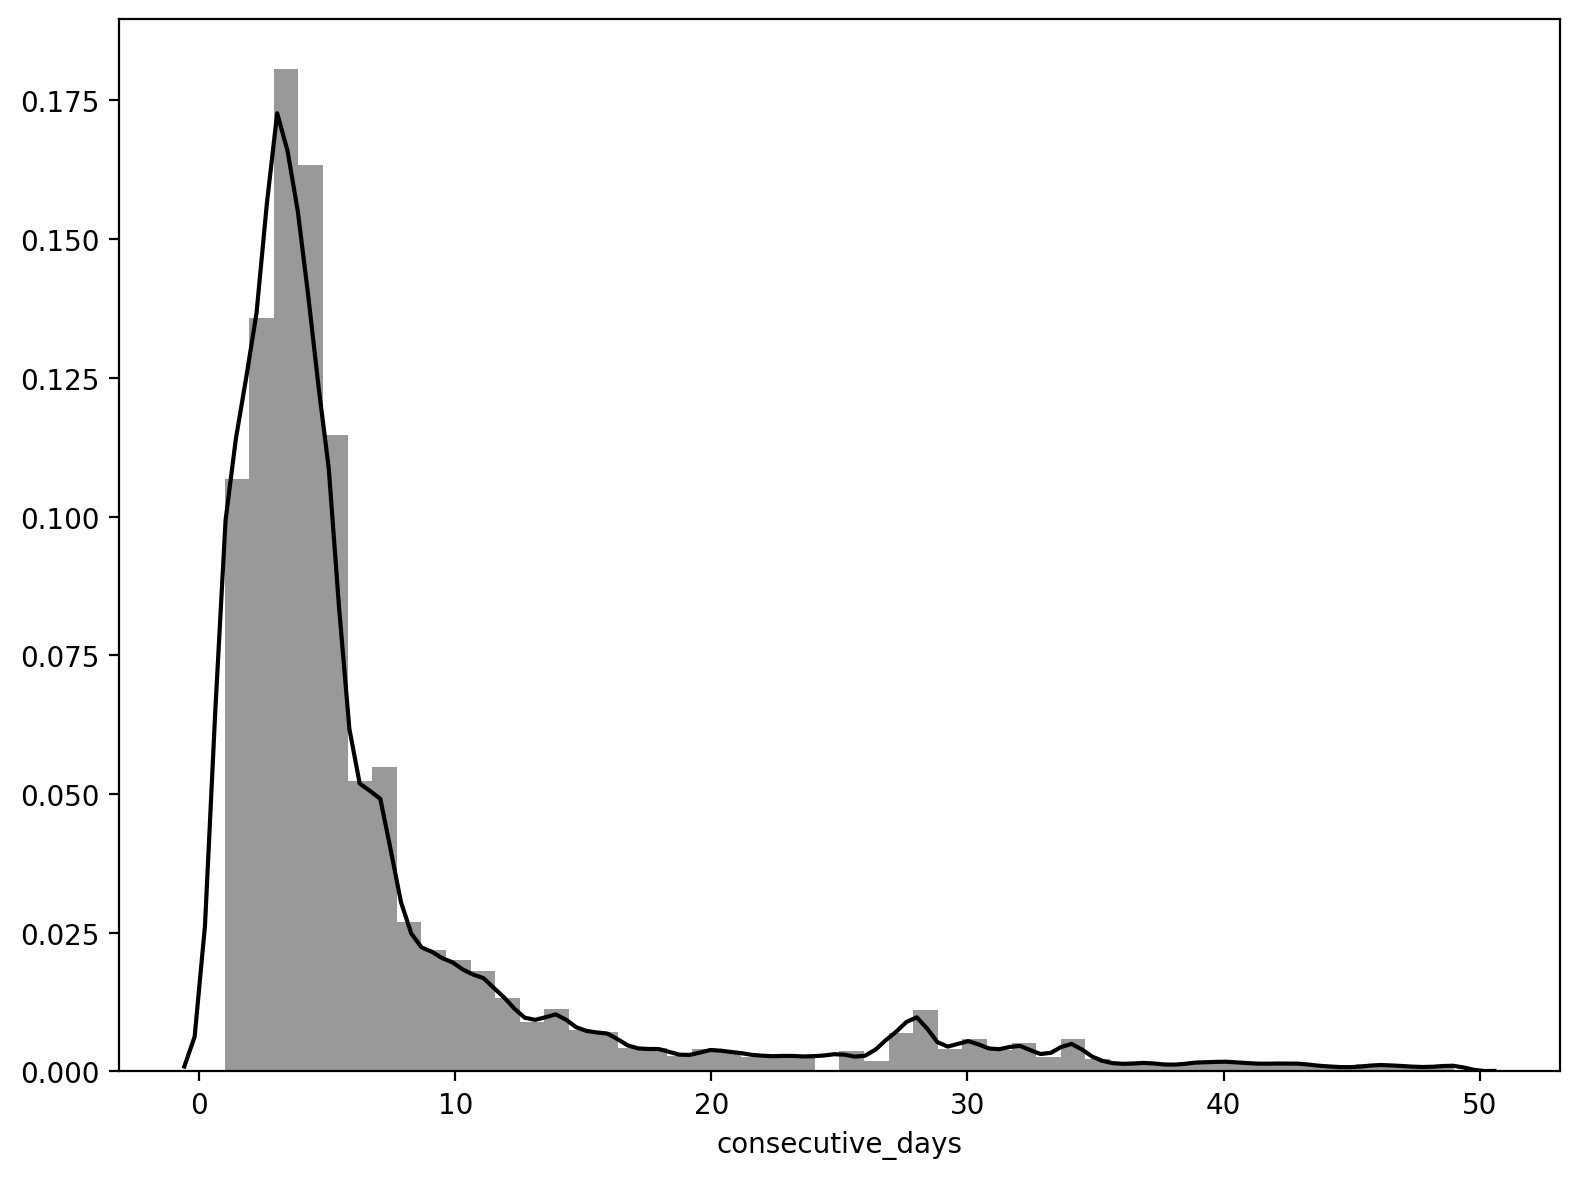

In [45]:
# Zoom in on the first part of the plot, to reveal more detail about regular rental behavior
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']['consecutive_days']
sns.distplot(consecutive_rented_days[consecutive_rented_days < 50], bins=50, color='k')
ax.set_yscale('linear')
fig.set_tight_layout(True)
fig.savefig('images/consecutive_small.png', dpi=200);

- Caveat, might not be distinct customers (neck to neck bookings)
- Might not show longer than a year bookings also, since we only look at data for a year (not so critical)


## Are there any property types that show a norm of amount of consecutive rented days

In [46]:
# Join the consecutive rental data with property type from listing data
property_vs_rental = (consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']
                      .merge(listings_clean[['id','property_type']], left_on='listing_id', right_on='id')
                     )

In [47]:
# Pivot so we have property type versus number of consecutive rental days
property_vs_rental_piv = property_vs_rental.pivot(columns='property_type', values='consecutive_days')

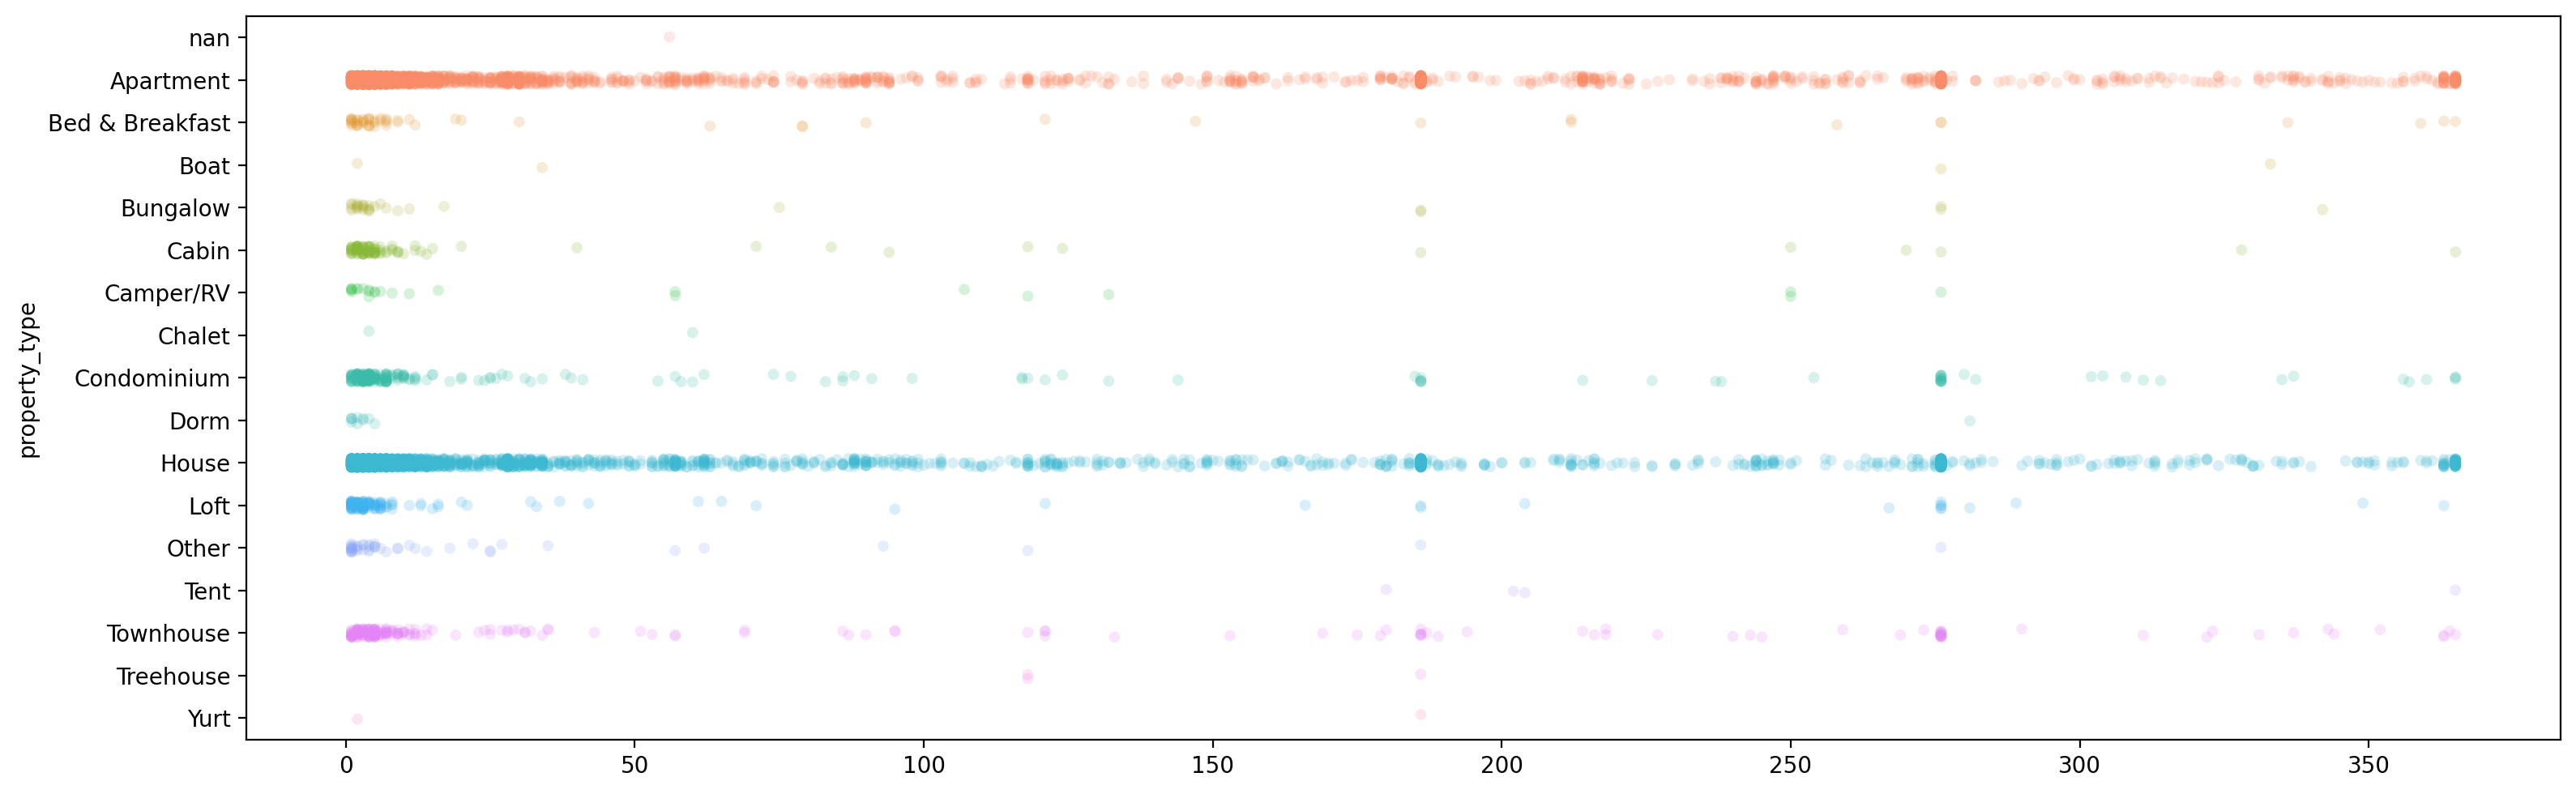

In [48]:
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.stripplot(data=property_vs_rental_piv, orient='h', ax=ax, alpha=.2)
fig.set_tight_layout(True)
fig.savefig('images/rental_days_dist.png', dpi=200);

# What features have inpact on price?

In this section I will use XGBoost regressor to model the listing prices versus features present in the listings data. This will to a certain degree allow me to understand what affects the price of a listing, given that it is possible to firstly model the data to a high enough degree, secondly that it is possible to explain the resulting model.

## Feature generation

In [49]:
# We want a response variable that always has labels, as opposed to the above analysis
calendar_clean = calendar_clean[calendar_clean['available'] == 't']
# Joining the listings and calendar dataset, and dropping price columns from listings in order not to collide with calendar price column
X = listings_clean.drop('price', axis=1).merge(calendar_clean, left_on='id', right_on='listing_id')

In [50]:
# Definition of selected columns and their types
continuous = [
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'host_total_listings_count',
    #'zipcode',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'square_feet',
    'cleaning_fee',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]
dates = [
    'host_since',
    'first_review',
    'last_review'
]
categorical = [
    'host_response_time',
    'host_location',
    'host_is_superhost',
    'host_neighbourhood',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'city',
    'state',
    'market',
    'smart_location',
    'country_code',
    'country',
    'property_type',
    'room_type',
    'bed_type'
]
# Response variable that we would like to predict
response = [
    'cleaned_price'
]

In [51]:
# Using pandas' get dummies to one-hot-encode the categorical features. This must be done before splitting,
# to ensure we get all possible columns in both datasets.
X_dummies = pd.get_dummies(X[continuous+categorical])

In [52]:
# We use sklearn to split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies, X[response], test_size=.25)

In [53]:
# In order to iterate faster, it is good to save the dataset to disk, 
# this avoids having to re-process the data every time the kernel is restarted.
X_train.to_pickle(DATA_FOLDER / 'X_train.pkl')
X_test.to_pickle(DATA_FOLDER / 'X_test.pkl')
y_train.to_pickle(DATA_FOLDER / 'y_train.pkl')
y_test.to_pickle(DATA_FOLDER / 'y_test.pkl')

## Modelling

In [54]:
# Load train and test data from disk
X_train = pd.read_pickle(DATA_FOLDER / 'X_train.pkl')
X_test = pd.read_pickle(DATA_FOLDER / 'X_test.pkl')
y_train = pd.read_pickle(DATA_FOLDER / 'y_train.pkl')
y_test = pd.read_pickle(DATA_FOLDER / 'y_test.pkl')

In [55]:
# Use the sklearn interface to XGBoost, using the regressor
reg = xgb.XGBRegressor(max_depth=10, eta=1)

In [56]:
# We start the training of the model, and set early stopping to 5 rounds. The eval set is set to the testing set
# this allows the algorithm to stop early given that it does not improve for 5 iterations.
model = reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5, verbose=True)

[0]	validation_0-rmse:44.39943
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:41.40580
[2]	validation_0-rmse:38.24595
[3]	validation_0-rmse:35.92318
[4]	validation_0-rmse:35.35961
[5]	validation_0-rmse:34.99038
[6]	validation_0-rmse:34.36098
[7]	validation_0-rmse:34.06799
[8]	validation_0-rmse:33.16943
[9]	validation_0-rmse:32.45869
[10]	validation_0-rmse:31.69494
[11]	validation_0-rmse:31.03574
[12]	validation_0-rmse:30.72069
[13]	validation_0-rmse:30.30153
[14]	validation_0-rmse:30.09279
[15]	validation_0-rmse:30.02742
[16]	validation_0-rmse:29.90007
[17]	validation_0-rmse:29.74129
[18]	validation_0-rmse:29.69019
[19]	validation_0-rmse:29.66506
[20]	validation_0-rmse:29.51411
[21]	validation_0-rmse:29.18569
[22]	validation_0-rmse:29.02467
[23]	validation_0-rmse:28.95894
[24]	validation_0-rmse:28.93924
[25]	validation_0-rmse:28.85708
[26]	validation_0-rmse:28.79845
[27]	validation_0-rmse:28.71435
[28]	validation_0-rmse:28.67828
[29]	validation_0-

## Model evaluation

In [57]:
# Run the model on the training and test data
y_train['prediction'] = reg.predict(X_train)
y_test['prediction'] = reg.predict(X_test)

In [58]:
# We evaluate the model by first looking at the difference in prediction and actual price,
# between the training and test data.
y_train['diff'] = y_train['cleaned_price'] - y_train['prediction']
y_test['diff'] = y_test['cleaned_price'] - y_test['prediction']

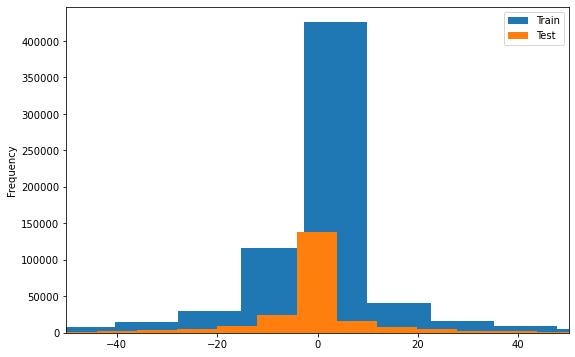

In [59]:
fig,ax = plt.subplots(figsize=(9,6))
y_train['diff'].plot.hist(ax=ax, label='Train', bins=150)
y_test['diff'].plot.hist(ax=ax, label='Test', bins=150)
ax.legend()
ax.set_xlim(-50,50);

Looking at the graph we get a fairly similar behavior between the training and test data.

In [60]:
# Calculate r-squared and root-mean-squared-error to evaluate training and testing performance
train_r2 = r2_score(y_train['cleaned_price'], y_train['prediction'])
test_r2 = r2_score(y_test['cleaned_price'], y_test['prediction'])
print(f'Train r2: {train_r2}')
print(f'Test r2: {test_r2}')

train_rmse = sqrt(mean_squared_error(y_train['cleaned_price'], y_train['prediction']))
test_rmse = sqrt(mean_squared_error(y_test['cleaned_price'], y_test['prediction']))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train r2: 0.9289531883704754
Test r2: 0.9273968587572327
Train RMSE: 27.992699626533426
Test RMSE: 28.343402171892755


## Model explanation

In this section I use SHAP values to explain how the model makes decisions on how price is set according to the given features in the listing description.

In [61]:
shap.initjs()

In [62]:
explainer = shap.TreeExplainer(model)

In [63]:
shap_values = explainer.shap_values(X_test)

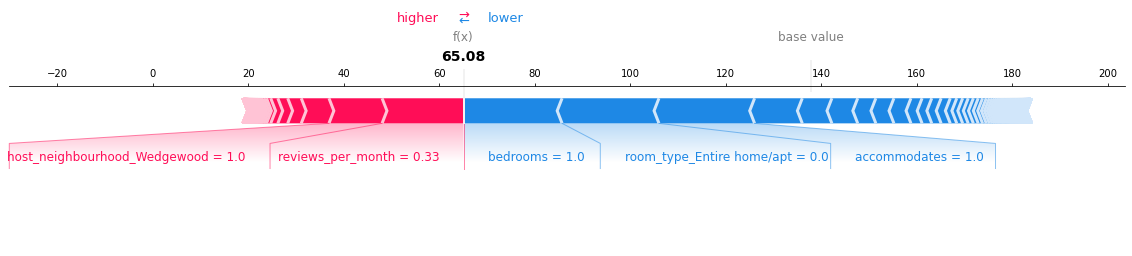

In [66]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)

invalid value encountered in greater
invalid value encountered in less


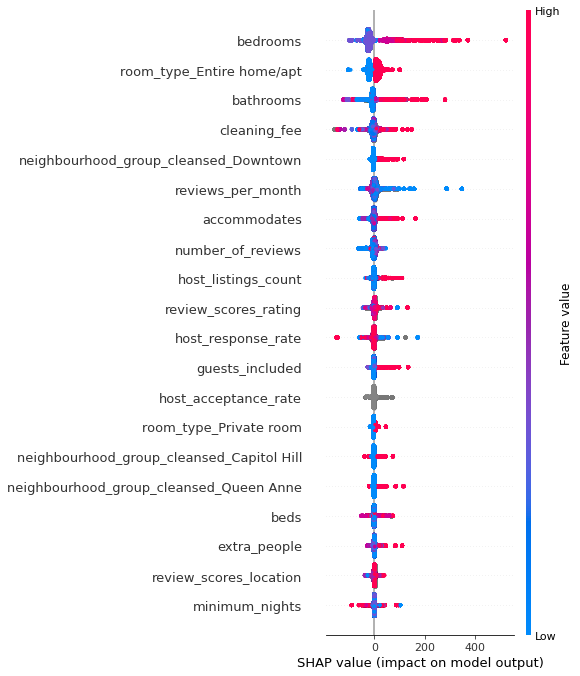

In [65]:
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGwAAAEACAYAAADm/uDaAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdd5hb933n+/cPfTrbDDuHXWwqVC8URZFqseSSdfYJ13Gi2I5LdpO1ldwb2k65zu4+2cjZJ7Y3jh1HKfa1fU03WdFGlkRJlCiJsiopiZRESRySw97J6ejn/vE7AA4wwHBmOACmfF7PQw7KmYOD3xwc4Hzx/X5/xnEcRERERERERERk9PBVewNERERERERERCSfAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIiIiIiIqOMAjYiIiIXo3FjU7U3QURERETGHwVsRERkaBo3HqBx48dL3PdlGjf+nyGs67s0bvynkdq0Kvk3Gjf+t3KsuPX+o8+03n/0z8qxbhEREREZ3QLV3gARERlHOjf/VbU3oQo+CTxD40bo3PwX1d4YERERERkfFLAREZHxo3FjkM7NiTKsdx3w9AWW+nMaN/6Szs0vjvjjV1Hr/UeD7ZtmjfyYioiIiMiAFLAREZHhmEfjxqeA64ADwGfo3PwCjRu/Aqyhc/NtADRunAE8AKwFTgD3A/8ELKBz8wF3XWEaNz4A/EegB/hvdG7+TvaRGjfeDPxPYAVwDvgW8Ld0bnbcQMqTwCeAvwSagYYyPN/t7rqLmQk8Avwf4KUyPDYArfcfvQz4OrAaOw7/AvzP9k2zUq33H/07INS+adZn3WWfA+a1b5rV6l7fBKxt3zTrbvf6R4A/BxYBx4D/0b5p1g/d+34X+DPgO8DngQ5gZbmel4iIiIgUp4CNiIgMxyeBDwN7gP8FfA9YUmS5HwLngblABPhJkWV+A/hN4LPAR4Af07jxMTo3t9O4cSXwS+DjwL+7j/EocAr4f93f9wO/hg1klCcTxGbtnC56X+PGnwIP07n5D8ry2EDr/UebgCeAb2Kf60JskCgG/A02aPU1d9l64ArgXOv9R5e2b5r1HnAbdhxpvf/o7cA/Y8d6O3A18Hjr/UcPtW+a9az7kPOBWdjxNuV6XiIiIiJSmgI2IiIyHN+hc/NbAG7T4C/0my2pceMcYD2wiM7NnUAnjRv/O3BLwbq20rn5YffygzRuPI8NOLQDvw/8lM7N/+bev4fGjd8EfodcwAbgi3Ru7hixZ1dC6/1HDVDfvmlWl+fm/0Tn5uNlfui7gTg2E8YB3mm9/+j9wB9hAzZPA3Nb7z+6EFgOvAK8D9zeev/RduAmd1mwWTPfaN806zn3+sut9x/9AXZMMwGbBPDF9k2zYmV+XiIiIiJSggI2IiIyHMc8l3vcn4WlSLPdnwc9t7VfYF2Z9WXWtQBYT+PG/+C53wcc8lxPF1wvCzdY88/u4/9u9o7yB2vAZigdcIM1GW3u7bRvmtXZev/RV7GZNMux2Th7gd/CZkF1tm+atcv9vQXAra33H/0jz7r8wHOe68cUrBERERGpLgVsRESkXI64P+cB+zyXh6Id+Bc6N/+XAZZx6NzsDHD/RfMEa67GZg1V2iGgtfX+o8YTtFlIfqDqSXIBm08A+4F/BN4DnvIs1w58t33TrL8Z4PHSI7XhIiIiIjI8CtiIiEh5dG4+TOPGZ4C/pnHjp4AabDPbofgWsI3GjY8BjwEOsBRopnPztpHc3Av4KDYIAnCq9f6jpZZb0r5p1t4yPP4j2IbDX269/+jfYLNkNmEbA2c8iS13igM72jfNSrfef3Q/tjfQFzzLfR3419b7j74IvIDNrrkUMO2bZr1ahm0XERERkWHwVXsDRERkXPsYUAscBp4HfurePrhym87Nu4F7sAGHY8BJ4LuUnrGpXP4N+AWwC5vZ0lzi375SK7gY7ZtmdQB3YDNoTgCPY3v4/K1nsV9h39e3tm+alcmQeRJodH9m1rUF+Ay2981p7Lh+Dagvx7aLiIiIyPAYxylrFrmIiEhO48Y7scGPmnKXMY201vuPBoDNQFf7plmfuNDyIiIiIiIXQwEbEREpn8aNl2PLmHZhy3h+DLxN5+Z7q7pdw+QGbSa1b5pVfIpvEREREZERoh42IiJSTlOAB4CZQAfwKPDHVd2ii9C+aVYSW0YkIiIiIlJWyrARERERERERERll1HRYRERERERERGSUUUmUiIhMZMeB6RV+zBPAjAo/pojIYFTjmDgW6TguIhWhkigREZnIqvUmaKr0uCIiA9GJweDpOC4iZaeSKBERERERERGRUUYBGxERERERERGRUUYBGxEREY/Tp0/zD//wD/zVX/0VL730Em1tbWzevHlQv/vAAw9w8uTJMm+hiEjlfP3rX2ffvn3V3oxheeaZZ3jwwQervRkiIsOmgI2IiIjH9u3bmT9/Pl/+8pe57rrreOqpp1izZs2gfvfGG2/k6aefLvMWioiIiMhEoICNiIiIR0dHBy0tLQAcOXKEaDTKnDlzBvW7l1xyCQcOHKCrq6ucmygiIiIiE4Cm9RYREXF973vf48CBAxw8eJDHHnuMm266ifnz52fvP3ToED/60Y/47Gc/S1NTE8ePH+e73/0uv/d7v8e0adMIBALMnDmTtrY2rrjiiuo9ERGREXTkyBEeffRRurq6WLZsGffccw+BQIC+vj5+8YtfcPjwYdLpNPPmzeOee+6hsbERgNdff51t27bR09NDbW0t69ev57LLLgNg586dbN++ne7ubmbPns0HP/hBJk2a1O+xf/CDH7B06VKuvfba7G3f/va3WbduHcuXL+fRRx/lnXfeIRaLMWXKFO666y5aW1v7refAgQM8+OCD/NEf/VH2tq9//et86EMfYuHChTiOw/bt23nttdeIRqMsXLiQe+65h5qampEeThGRQVOGjYiIiOvee++ltbWVD3zgA3z5y1/mxIkTTJ06NXv/3Llzueqqq3jooYdIJBL84he/YP369UybNi27THNzMydOnKjG5ouIlMWuXbv4+Mc/zuc//3nOnDnDs88+C4DjOFxxxRXcd9993HfffQQCAX75y18CEI/HefTRR/mt3/otvvzlL/OpT32KGTNmALBnzx6ee+45fvM3f5M/+ZM/obW1lZ///OdFH/vSSy9l165d2eunTp2io6ODJUuWADB79mw+97nPsWnTJi699FJ++tOfkkwmh/wcX3rpJfbs2cMnPvEJ/viP/5hIJMIjjzwy5PWIiIwkBWxERERKiEajhMPhvNvWrVtHNBrlgQceoKGhgWuuuSbv/lAoRDQareRmioiU1bXXXktTUxM1NTWsXbs2G0Cpra1lxYoVBINBwuEwa9eu5cCBA9nfM8Zw8uRJEokEDQ0N2XLTV199lTVr1tDc3IzP5+Pmm2/m+PHjnD9/vt9jL1u2LO++N998k+XLlxMI2EKByy67jNraWnw+HzfeeCPJZJLTp08P+Tm++uqrrF+/nsbGRgKBAOvWrePtt98mnU4PeV0iIiNFJVEiIiIl1NTUEIvF8m7z+/1cccUVPProo9x5550YY/Luj8fjRCKRSm6miEhZZUqcAJqamrJ9uhKJBI899hh79+7NBqpjsRjpdJpQKMRv/MZv8MILL/Dwww8zd+5c7rzzTqZNm0ZHRwePPfYYW7Zsya7XcRy6urr6lUWFw2GWLl3K7t27WbNmDbt37+aDH/xg9v4XXniBHTt20NXVhTGGWCxGb2/vkJ9jR0cHP/7xj/OO6T6fj+7u7rznLyJSSQrYiIiIlDB9+nTOnDmTd1tnZyfbtm1j9erVbNmyhU9/+tPZb3rBputnejSIiIwHnZ2d2csdHR00NDQANlhy5swZPv3pT1NfX8/x48f5h3/4h+yyixcvZvHixSQSCbZu3crDDz/MJz/5SRobG7n55psHfaxctWoV27Zto7W1lWQyyYIFCwBob29n+/bt/M7v/A4tLS0YY/jrv/7rousIBoMkEons9XQ6TU9PT/Z6Y2MjH/7wh5k3b97gB0ZEpMxUEiUiIlLCkiVLaG9vz153HIeHHnqI1atX86EPfYj6+vq8abyTySTHjh1j0aJF1dhcEZGyePnll+ns7KSvr4/nnnuOVatWATajMBAIEIlE6Ovr45lnnsn+Tnd3N++++252mVAohM9nTz2uvvpqnn/+eU6ePAnY8tO33nqr5OMvWbKE8+fP8/TTT7Ny5cpsFkw8Hsfn81FXV0c6nWbbtm39siIzpk6dSjKZ5L333iOVSvHss8+SSqWy91999dVs3bo1W3rV09PDnj17hj9oIiIjQBk2IiIiJcycOZNwOMzhw4eZM2cOL730Ej09Paxfvx5jDB/5yEf49re/zdKlS2ltbeXdd99l/vz52W+fRUTGg0svvZTvf//7dHV1cckll7B27VoArr/+en7+85/z1a9+lYaGBm644YZskMNxHF544QUefPBBjDHMmDGDu+++G4Dly5cTj8f52c9+RkdHB+FwmEWLFrFy5cqijx8IBFi+fDk7d+5kw4YN2dsXLVrE4sWL+bu/+zuCwSA33HADTU1NRdcRiUS4++67efjhh3Ech5tuuimv1On6668HyD7Puro6Vq1axbJlyy5+AEVEhsk4jlPtbRAREamWC74JtrW18corr7Bx48YLruyBBx7gwx/+cLax5gDMhRYQEakCnRgMno7jIlJ2CtiIiMhEVq03QX3QF5HRSCcGg6fjuIiUnXrYiIiIiIiIiIiMMgrYiIiIiIiIiIiMMgrYiIiIiIiIiIiMMgrYiIjIeHIc24NhsP+qZSjbeLxK2ygiIiIiVaSmwyIiMp6M1zc1NbcUkUoYr8fQctBxWUTKThk2IiIiIiICcKLaGzBGaJxEpCKUYSMiIuPJeH1T0ze5IiIiIhOMMmxEREREREREREYZBWxERGRCOHPmDF/4whdYsGABoVCIqVOnsnbtWnbu3AnAunXrMMb0+7dmzZoLrjuRSPCXf/mXLFy4kFAoxJw5c/jCF75AV1dX3nJPPfUUt99+O9OnTyccDjNz5kx+/dd/nddee60sz1lERERExq5AtTdARESk3M6cOcN1111HW1sbfr+fxYsXEwwG2blzJ21tbaxevTq77MKFC2lubs5eX7ly5QXX/8lPfpIf/OAH+Hw+lixZwr59+/jGN77B66+/ztatW/H5fOzZs4cPfOADxONxJk+ezMqVK3nrrbd46KGH2Lp1KydOnCASiZTl+YuIiIjI2KMMGxERGff+7M/+jLa2NmbPns0777zDnj172LVrF+fPn+cDH/hA3rJ//ud/zosvvpj9953vfGfAde/YsYMf/OAHAHzjG99gz549/PznPwdg27ZtPPTQQwC8+OKLxONxAB555BF27NjBV77yFQC6uro4d+7cSD5lERERERnjFLAREZFxzXEcfvKTnwA2e+ZjH/sY9fX1rFixgn/8x3+kpqYmb/n77ruPcDjMwoUL+cxnPsOJEwNPBvLoo49mL3/0ox8F4O67785myzz++OMAXH/99QSDwez9V155JV/5yldoaGjgq1/9KjNnzhyZJywiIiIi44ICNiIiMq6dOnWKs2fPAvDcc8/R3t5Oc3Mz77zzDv/5P/9n/v7v/z67bE1NDbNnz6a5uZn9+/fzwAMPcMMNN9DT01Ny/YcOHcpebmlpAcDn8zFt2jQADh48CMCyZct44oknaG5u5ty5c+zcuZN4PM7s2bNZtWrViD9vERERERnbFLAREZFxLZlMZi9PnTqVtrY29u7dyw033ADAN7/5TQC+9rWvce7cOXbv3s2hQ4f40pe+BMD+/fv5xS9+UXL9jlN8JvHC248cOcKnPvUpTp06xfe//326u7vZtGkTe/bs4UMf+hD79++/qOcpIiIiIuOLAjYiIjKuNTc3EwqFAFi6dCkNDQ34/X6uuuoqAA4cOADA6tWrCYfDABhj+NjHPpZdRyZLpph58+ZlL588eRKAdDrNmTNnAJg7dy4A3/rWt2hra6O2tpaPf/zj1NXVce+99wJ2lqlt27aNxNMVERERkXFCARsRERnXgsEg69atA+C9996ju7ubdDqdnc576dKlnDx5kr/927/Nm4b7xz/+cfby/PnzAZsls2zZMpYtW5bNurnrrruyy2WaDT/yyCNEo9G8+zs6OgDo7e3lrbfeAuDVV1/N/m5dXd2IPWcRERERGftMqVRuERGRMajom9orr7zCzTffTCwWo6Wlhdra2mxmzc9+9jOuuuoqFixYQCAQYPHixfT09GR70yxfvpwdO3YQiUQ4cOAACxYsAOBf//Vf+d3f/V0APvaxj/GjH/0In8/H0qVLaWtrI5FIsGbNGrZt24bP5+Opp57i9ttvx3EcamtrWbRoEW+//TapVIoZM2bw7rvv0tjYWOp5mZEcJBEREREZ/ZRhIyIi494111zDM888w4YNG+jp6aGjo4NbbrmFrVu38tGPfpTm5mb+9E//lNWrV3Py5ElOnz7NsmXL+OIXv8j27duzMz6V8r3vfY+/+Iu/YN68ebS1tTFt2jT+8A//kEceeQSfz77VbtiwgV/+8pfcdtttNDQ08N577zFnzhzuvfdetm/fPlCwRkRkQurq6nK6urr07bKITFjKsBERkfFkvL6pKcNGRCacTLCmoaFBx0ARmZCUYSMiIiIiIiIiMsooYCMiIiIiIiIiMsooYCMiIiIiIiIiMsooYCMiIiIiIiIiMsooYCMiIiIiIiIiMsooYCMiIiIiIiIiMsooYCMiIuPJiWpvQBmMx+ckIiIiIhcwrgM2xpi/McbsMca8aYz5hTFmkue+Lxlj9hpj3jXG3FnN7RyvjDF3ueO71xjzxWpvz3hnjJlrjHnaGPOOMeYtY8zn3dunGGOeMMa87/6cXO1tHa+MMX5jzE5jzL+71zX2FWKMmWSM+Zkx5rx73L/RGDPVGPOkewx60hgzBTAj8a+rq4uuri5Gan0X+DejLIM2Qowx97nHnN3GmB8ZYyLa98vHGPMvxpiTxpjdnttKjrc+74ycEmOvz5oVUmz8Pff9X8YYxxgzzXObxn+ElBp7Y8wfuuP7ljHmq57bNfYjqMSx5wpjzIvGmNeNMa8aY6713KfxHyHDOb8a6fEf1wEb4AlgleM4lwHvAV8CMMasADYCK4G7gG8ZY/xV28pxyB3Pvwd+DVgB/Cd33KV8ksAfO46zHLge+C/umH8ReMpxnCXAU+51KY/PA+94rmvsK+cbwGOO4ywDLsf+HTT+ZWaMmQ38V+Bqx3FWAX7s+6vGvny+i/3s4lV0vPV5Z8R9l/5jr8+alfNd+o8/xpi5wO3AQc9tGv+R9V0Kxt4YcyvwYeAyx3FWAv/LvV1jP/K+S/99/6vAXzqOcwXwF+51jf/IG9L5VTnGf1wHbBzH2eI4TtK9+iIwx738YWCz4zgxx3H2A3uBa4utQ4btWmCv4zj7HMeJA5ux4y5l4jjOMcdxdriXu7AnrLOx4/49d7HvAR+pzhaOb8aYOcDdwD95btbYV4AxphFYC/wzgOM4ccdxzqPxr5QAUGOMCQC1wFE09mXjOM6zwNmCm0uNtz7vjKBiY6/PmpVTYt8H+BrwJ4DjuU3jP4JKjP3vA3/tOE7MXeake7vGfoSVGH8HaHQvN2Hfe0HjP6KGcX414uM/rgM2BT4JPOpeng0c8tx32L1NRo7GuIqMMfOB1cBLwHTHcY6BPegALdXbsnHt69gPjGnPbRr7ylgInAL+1S1J+ydjTB0a/7JzHOcI9lvVg8AxoMNxnC1o7Cut1Hjrvbiy9FmzwowxHwKOOI7zRsFdGv/yWwrcbIx5yRizzRhzjXu7xr4yvgD8jTHmEPZ9+Evu7Rr/Mhnk+dWIj/+YD9i4fQl2F/n3Yc8yf4pNZ/ph5qYiq3KK3CbDpzGuEmNMPfBz4AuO43RWe3smAmPMPcBJx3Feq/a2TFAB4Erg247jrAZ6UAlORbg12x8GFgCzgDpjzMeru1XioffiCtFnzcozxtQCf4otB+l3d5HbNP4jKwBMxpaJ/N/AT4wxmd5rhTT2I+/3gfscx5kL3IebZYzGvyyGcH414uMfuJhfHg0cx7ltoPuNMfcC9wAbHMfJDNZhYK5nsTnk0shkZGiMq8AYE8QeTH7oOM6D7s0njDEzHcc5ZoyZCZwsvQYZppuADxljPgBEgEZjzA/Q2FfKYeCw4zgvudd/hg3YaPzL7zZgv+M4pwCMMQ8CN6Kxr7RS46334grQZ82qWYQNFr9h4wTMAXa4zVc1/uV3GHjQ3edfNsakgWlo7CvlXmzvRICfkivJ1/iPsCGeX434+I/5DJuBGGPuAjYBH3Icp9dz18PARmNM2BizAFgCvFyNbRzHXgGWGGMWGGNC2OZLD1d5m8Y191uNfwbecRznbz13PYw9qOP+/LdKb9t45zjOlxzHmeM4znzsvr7VcZyPo7GvCMdxjgOHjDGXuDdtAN5G418JB4HrjTG17jFoA7a+W2NfWaXGW593ykyfNavHcZxdjuO0OI4z333/PQxc6b4naPzL7yFgPYAxZikQAk6jsa+Uo8At7uX1wPvuZY3/CBrG+dWIj/+Yz7C5gG8CYeAJN/L+ouM4n3Mc5y1jzE+wH+iTwH9xHCdVxe0cdxzHSRpj/gB4HDtryL84jvNWlTdrvLsJ+G1glzHmdfe2LwN/jU1T/RT25Oo/Vmn7JiKNfeX8IfBDN0C8D/gE9ksJjX8ZOY7zkjHmZ8AO7PvpTuAfgXo09mVhjPkRsA6YZow5DPw/lDjW6PPOyCox9l9CnzUrotj4O47zz8WW1fiPrBL7/r8A/2LsVNNx4F4320ZjP8JKjP+ngW+4Df+jwGdA+34ZDOn8qhzjb3KZmyIiIjIYXV1dDkBDQ0OxWmURERkBOtaKyEQ3rkuiRERERERERETGIgVsRERERERERERGGQVsRERERERERERGGQVsRERERERERERGGQVsRERERERERERGmQkRsDHGfKba2zCRafyrR2NfXRr/6tHYV5fGv3o09tWl8a8ejX11afyrR2NfXeUe/wkRsMGdl16qRuNfPRr76tL4V4/Gvro0/tWjsa8ujX/1aOyrS+NfPRr76lLARkRERERERERkIjGO41xwobvuuss5ffp0BTanPE6dOkVzc3O1N2PC0vhXj8a+ujT+1VPusU+n0wD4fPreoxjt+9Wjsa8ujf/IGsqxVmNfXRr/6tHYV9dIjP9rr732uOM4dxW7b1ABG2BQC4mIiEwEXV1dADQ0NFR5S0RExi8da0VkgjCl7tBXgyIiIiIiIiIio4wCNiIiIiIiIiIio4wCNiIiIiIiIiIio4wCNiIiIiIiIiIio0yg2hsgIiIiIiJSSM2GRWSiU4aNiIiIiIiIiMgoo4CNiIiIiIiIiMgoo4CNiIiIiIiIiMgoo4CNiIiIiIiIiMgoo6bDIuPFjreh170cNBAOQW0EImHwG/vP5wO/H3ye6w4Q9NvfM+5/Pp9dxmcgnoRwEGIJCAXAGLtsIuWup0jcN5WGtJNbbykDraMUx4FYEiLBwf/OxUinIZm2z328cJzc31VkjEqmHPdQZaq9KRNWIuUQ8IHR36Aq4imHkH9sjn0q7eAAAV9ltz+ecghWYJ8dqccZTesZyut9sMfnwWzXYNaVSjsA+IvsT6Ueo9jrJ5l2MAXrSTsO6TQEPMsWW867Pu/+7f39zHMxQCINIb8h7o5rOg1pwODgA9IYnMzKHQdj7Ed2xwHjQNqAk3bAGBzHXdIBx2R/Bcdxsj/tdkHKsR+/Uw4kkvYjbjSdG4PLZuqz4Whjsn/ggQ1qIRGpgufftj8dJxdM8V6/0Gs8s4zj2CBL5vcOnYaWSdAbhWQKZkyG/+9Z+45ywzKY3wJP74Kd+3LrmtoA1y2FpbNhRxs8+1bxx5wxGW4ssY5SfAZWL4SrF9tAw7d+ad9lyqWhBq5ZAivnQftJePjl8j1WpdSE4KrFcPl8ON8DP9xW7S0as7p++HkAPvtIrMpbMnHdc0kNi6cG2X0yziuHY3RE9VGl0n7rijqm1Ph441icV47E6Uvob1ApTRHD565t4FRvmpcPxdh9IlHtTRqSq2aHuHVhhP1nk7xwMMaxrlRFHvdTV9cTCRhePxbn1cMxYmV42JAf/uCGRnriaV49HGfH0fiwT6Q+e209AZ9hx9E4rx2JER/m9n7yqnpqg/Z5v3IkRiw59HX89uo6JkV87tjF6UuWflaZ4/NbJ+O8XOL4HPDZcYom0rx6xI5Tusgq71wSYXlLiHdOJnjpUIzz0f6f/a6bG2JNa4S2swl+dTDGiW67jN/AH9zQQDwFrx6JseNInJQDkYDhD25ooDOa5pXDcXYeiwOwdn6Yq+eEee90ghcPxjjdm2ZFS5C7L6nhUEeK7e1RDnWkWLsgzNWzc8ulHPjstQ2c7E7x0qEYkaDJ7t8ne1JcPzdM+3k76LMaAuw/l2B5S4iT3Sma63x0xR3qQ4aU+9Qy35lCLkgD+R/zDTYIVXgu772t8P7Mde9PL8cNDIFR4KbySkYkx9FXxiITXOE3D5nrg/k2xRj7z5voMr/F3lYXzt3W0gTvHYXFM+31hdPhaw/n7r9uKXyq1V5eOgv+x08o+u77gas865iRv46BfOwWaKqzl5NpeGb34H5vOOZOg9//NXt50UzYsQ86ewf+ndGusQY+92s286kuAvtOwMFT1d6qMW17e7zamzAh1QUN993USDhguHp2mB/s7KXt7DDOQGTY5jT6mdtkP0ZeOzfMt1/q5ryCZhXz8StqMcbQUudner2f77zcU+1NGpLfvKyOgM+wZFqQx9+PVuRYesm0AM11NvP36tlh/u6F7gGDDsN155IIIb8hVONnybQg//tX3cNaz6XTg0yusdt71awQ//uFrmEFbBZPDdBSb9dzzZwwf/erbnqHGFyd1+RndqP7ep8T5lsvdtMZK74O7/H5qtlhvl/i+HzrwjCRgCES8LOiJcg3Xug/TuEA/NcbGogEDKtnhdj8Zg9vn+y/rkH1npIAACAASURBVN9eXUfQb1jWHOKX7+b2pzXzw9QEfdQEYVVLiG9s78YBPrishoDPMKXWz4IpAb75Yjc+A5++pp6Q37Bqeoh/e7uPFw/F+cAlNfh9hvmTAzy73/Crg/G85X7xVh/Lmm1wo6Xen/2X2b/rwz78PsPCKUGSaYeAz7C8JZRdHqAxbD+r+4okppvsf8UVy07y3lZ4f+b6hX5PRg/1sBEZ69asKM96ix20b14BL79ry6PABjIWzcjd/8r7cKbLXp7SYDNUinlmN0Qz65iRC95cyJaduct3rh7c7wzXodPw9iF7OeiH9ZeW9/EqobMPXtyTu17uMRQpk7ULwoQD9hjVdjahYE0V3LY4kr388qG4gjUV5DOwYVFu/Le8H63i1gzdkqkBFky2J//RhMOzByqTqXj7ktyYPXcgWpZgDcDti0fmb+Pd3qf3Dz+7xrs9z7fHhhysKdyWlw7FSgZrYPDHZ+92PbG3+DjdNC9Mbcierh7uSBYN1qxsCWaDST3xNC+05/anOwoeI7PV3ueT+RtdNSvE1FobMTnXZzNvZjb4uGyGDa6k0g5PtUW5anZuuTO9KXYcjbNhUe7LzV3HE9n9O5ZwmNngz/5+pgQwPbgKFxFAARsRGYyk+ykhEoKrl8D2d3L3eU/60w489Ubx+7x6Y7lSroGWK/TkG2TzRS9fADMnD+73hquSAaJKefz13OX1l0HgAn2GREahOzwftp8YYyer40HAB+u9AYMSJ1tSHlfOCjGtLv/Ecizxvn6fb49VpJSuJmBYO7/8Qa7WSX4ucbMtEimHZ/YP73HqQoabWnNBgCfe7xvWesIBuGWBdz1D356AD9YvHPzr/Y4iwZBCMxv8XJoXCCketLtjSc0FH9f7eNv258rcptf7WD3LPkbascEWKB0w9K7nqbYoKQduW5x7/NeOxDnbl85bbmtbjCtnhZjiCeDMacp9rjrenYuyeffz0d57TeVQo4sCNiLjQUuZqhsz5Uzek/o7VsNjnkDGukvtJ4KMLZ6AwDVLYEp98XU/7l3Hqvx1lHK222bxeLelnJ59ywaXAFpbYNmc8j5eJby+D06et5ebauH6pdXdHpEhWjglwOKp9sNkPOXwzH71Eaq0a+aEmFxjP0Ke7kmx8+jYChiMdd7MhK3uieVYEQ7YPiEZW4YZiBgqWxpjT5IPnk/y7unyZOV5/za/Ohija4BMlIGsWxDONrB9/3SC/eeGl15z07wwdW6GypHOJG+dHHqvo+vmhmiM2HWc7E7xxrHS6yg8Pm8rcXz2jtMrR+Kc6+vfl2ZOo5+V0+26kmmHp9v6B2zqgvmBLW+A6DZPUHnHkTine+1jFAsYTq7xcc2cUPb2J96PuplsnnXvjdrlZnuW2xvNDxjti+Xt31Prcqfa9WF7Wdk1MlQK2IiMB0vLdNLt7bafdt9ML5kNPVE4csZer4/ATctzyx09C28esJf9Prjt8uLrfusgHD5tL9dF4KZBlnZ5s15uuzx/G0daNAHPeRon33lF+R6rUtIOPOHNgrqyetsiMgzeD/ovtMfoievDb6V5/wZPtkWLtiqT8pgUMVw7N3fC+OQYy25a05pf4vLOqcqUM45UmdJAgj64ddGFy3wGw5tZcjHruX0EshG923Kh17t3nLeXOD77CwIhpbZrMGWX3vKrfWeT2fIrn4ENRUquCgOGT+y1AcP1C8PZGZ92H49ztCuVV/p0rs82kN6wKLfcruNxYkmHqz0BnI5YOrt/n+lJUe9e7kvkAlKZ7JpBTvxTcZELLyIVpoCNiAyON33zjivyM2kKT/q92TN3rC7dLM27jrsGmS3zyl446/bJmdpgS7TKyZtNtHaVnWlprHvi9Vz21OqFtpm0yBgQ8sO6hcW/TZXKmFbr48pZYzdgMNatXxTJ9sF460SCw52VmV1ppOSVuFTo9Tuvyc/yllyZ0tP7yvO4188L0+hmUZy4QCbKQBZNCbBwitsDJenw7DCzCGc3+lk1Pb//ylA11/m4wi2PSTvOgK/3wR6fr56TX0L06pH+GXqDLbvML7/KZWutnhnKNpg+35fmZbdssDBgmOmJk7ce97GKlUjdvjh//13vCeC8eTzOdXNzz9/bI6nYdOOjtcHvUpVDjToK2IiMF+VqPpzhfWNZfxls253rJ3NpK8yekrt/+zvQ7b65zpoCl84vvs6n3sj1x1nVCrOnXng7Umnbyyaj3L1l3j0CB07ayzUhWLuyvI9XCSc77LTrYL+Gun0cZA7JhHDjvHD2G8ujnakxN5XxeLBhUSR78vH6sXh2+lypjPxMkcqUE42UOU12NiCwJS5byxQ4KTSUhrkX9TiL87NZhvsohSU7PcPs8ePdnpcPD68x+G2LI9mMkJ1HE5zqKf16H+zx2btdT7XFimbsDKbscqDy2Lw+M/uiJNOZ2/sHDFdNDzKroGlxYenTlvej7nI2CNQdT/Org7G8AM5rh+N5+3dm2bTjZMvbUkpHlGFQwEZEBi8TXGmogeVz4GVPP5nbPYGTeBKe2ZW7fkeJgMC5nvx1lFqukDcz59olMLlEn5yRsqUgY2g88D6n268ob2mZyAjxnng9uXf4J0QyPIbKlJZIcStagsxxp1LvjafZfnBs9W+6vaDEpaMCM4sFfHDrEBrmDlepBrdDFfZffJNgsGVH3gyV4azHZwpncho4QJhXflVi2Sk1vrwSoidLLDeYsstS5bFNBWWDmec+p7F4wNC7nkzTYm/p0+7jcY51pfJmnNq2L8aSafkBnCm1udPqo52pbKDLWxZWLNNmNJlXc+FlpPIUsBEZT8p1oC3VfNhb+nTbZbZnTYa3lGjNCtvrppjHC3rS+AdxWBpsn5yRsvVNSLjBquVzoLW5vI9XCS++Bx099nJLE1yxsLrbI3IBMxv8/aZXlcq6bGaQ6e4UtZ2xNC+OsYDBWHdH4YnlGJrNvt9MQxUK9l03N0TTIBvmXoxSDW6H6sbWi28SDPkZKmd6U7w2jMbgl88MZsuKOqJpXjpUeh2Fx+etJWZ9KiwhOtbVf5wGU3Y5UPnV+oW5ssG3T+bKBr0BpUzAsFTT4rzA9N4odSHDja35DYgLmw3fsiB3PVMaB9DgXh6tPWu8Jk1SOdRopICNyHhyVZnKovKaD3t6nxw6BWfcfjJTGuCaxbnl9h2Hvcfs5VDAziZVzGt74XSnvTy53mbMDEZe1kuZS3o6++DFPZ7HGwdZNskUbPVkQY2Xactl3PJ+gM5MryqV5Q0YPLMvSkJ/goqpDRrW5DVLHVsBy2vnhJjkBhBO9aTYeawyM4sNpWHucJVqcDscd4xAk+DC9Ty1d3jP+w5Puc/TnrKiYrzH51dLHJ9thp6nmXKJ5zeYsktv+dWxrvzyq2J9bUpNTX7LwlzT4razCdrOJouWSN3iaW7cdibBie5UXqDnRHcqu3+fj+Yux5L9B34sBG5kdFHARkSGyPNGc9vl+f1kCgMZ3uyZUgGBtDO8njTePjmzp9oeOOXkzRhaf1l+ttFY5f37XH8JNNZWb1tEBlBselWprIaw4YZ5F1+qIcOzdn7uhHH/2STvnxlD6TUU9C0ZZgBhqIbSMPdilGpwO1SzGi6+STDA1IIMleEEkBrDhuuKlBUV0+/4XGLZlQU9YF4okqE32LLLwtmvMrvT8uZAftlgu32MazwBQ29PnGKPVaxE6o6CjJtbPNOu7z2T4LIZucyUTk+pnzc2k2kyPFqbDV+mZsOjlgI2IuPN6jIFLjLvOj7PYeP2K+BJTz+Za5bApLrc9Wd25freLJoBC6cXX/cTnnVctRgm1xVfziuWhGc9U27fXuayqNf35TKBmmrhujLPTlUJB0/ZpsoAQT/cuqq62yNSwupZuVlFOqJ2elWprJvnhwn6c98wHzg/tmYnGus25DVqHVvBssk1Pq709C2p1PbfujDXMHfX8YEb5l6MDYtzwYpt+wfORBlwPZ6gx46jw2sSDHCrd4rqE3GOD6Mx+C0LItnX+/unExzsKP1673d8LjLrE+SXjT1/IEa8yCpXTs+VXfbEi5ddTq/3ZcuvIH9/8r5Oth+MEXXjmhs8j/30PtvouHWSP9u0OJl22LY/RiRAXubMU21R5k/ys8i73L5Y3nP51cF43v6dCUoBRIJ2DNNqNiwXQQEbkfHmwMHyrLfYe82xczDTMztUVx90exrINTflMlESqVzAo5B3Hd1R6Brkh7mZk3OXj58b3O8MV10kPwPlWJkfrxL8vvwpvcfDc5Jx6URX7pN9XcjQEB6d31COZyc8vSam1fkJ6BNkRR33vAZmNIytDM+uWJpuT+PVSm3/ie7cmE2v91Ouo8Zxz2vjYp6bN7Ayvf4i1tOVv57h9Ln17m/T6vz4B1hH4fG5scTx+XjB36OYk90p0u4XhDVBk82K8TofTdMbLz7mea+T+hK3N9h1nu1Lk0jZxwr4DM21PmJJOOcp55pR7+dMwXLT6nx5z2VSxOTt394mw1l6y5KLoLdbkfHmXJmi+Jl3/KTnK5HHd+T3j3nqTfK+WvLe96s9thdMMXd6ltv6Zv5jlDJ9ku2jA3aq7yfeGHj5i7XuUtuLB+D9o7DvRHkfrxK8M2yd7oRX91Z3e0RKONyZ4m23+WbAZ7h1UYkm5lI2O4/FOdVjj81NER/Xzgld4DdkJHlLQ9YtCBMaQzGbZBqe9mRBeEtOyumF9hhdMfuZZEaDn0tnlKfkw1tydPXsEFOKBBkG47kDUXrdxlDzJgW4ZFpgWOt58VCMzqhdT3Odn8uHUery2tE4Z3rt631yjY9rBni99zs+Lyz+931ybzQbjFk9K8T0+v7jdLInnW0M7TMmLzMmI5aEZw94pvD27E9b22LZqbMvnRFiphvM8f6Nrp8bpjFs6Io5eWVZty+J4BQse/uSCF0xh195l1scyXs93rIwwjbPFPXnPQGfzP7nG6VlUF7xeHkacsvFU8BGRIYmkzHTE4Vd7bb3SYa3EXDAb3u9ZHj7pXg11sL1yy68XCFvMGhHW+nsnZHi7a0z2G0c7bzP6ck3qEhTAZFhyjSPhPwP6FIZacf2HsnwNnOV8tt9IsExN0ugPuzL6yc0FnhPgm+YF65IllwiDc/s95zYLynPceNYV4pdx20ZkN9nWL9oeH+baNKWCmUMd3uTadskOLuexUN/rfZ/vQ+8LXnH5xLLnu5Ns/NoLihwW4nAu7dH2W2LI0WTU7wBkzXzw9S6pUdn+/JLsjLBwfbzKd49ZR876Desc4NK3v3y1oURgj5bBpUJ+lwx0waW8pZbFOGtE4lsBldj2MdJT7mdtySqLpjb+tFeFrXnTLW3QEpRwEZkPHn+7fKu39s97elddrruTADn7UNw6HTu/hs9TWxPnLc9YIpZf6ntnwLwzmHbV+VCfMb2z8kodwBl8UzbgwcgmoBtu8v7eJUwtcH2C8rY8nrpZUVGge3tsWwa/JymACtahvftswzfE3nfkAdprtPHyEpxyG/8WqkslZHS74R5QWW23xtIuGFemPpQeQJFW/L+NsMPZnrXc/P8CDWB4W2vN+hx3dxQyTKlgXiDFFfOGjhzaLDHZ+/fY8PiSNFyrRcPxuh0M1Om1xfPEHr/TJL952yDmnDAsHZ+8abHGxaFs4/hHZPM6+fNY4lsSVeDGwg905tmh2ca9NsWR3jjWH6A5rp54bwm1lfOCuXt34c77Lb5fCZbTuUbTm2aCArYiMhQeAM2W14fOOvkzivzly31xULeOnYMbjuuXATTGu3lc93w8nuD+73h8m7j829DT/8meGPObZfbHjYAb+wvfw8gkYsU7ZcGrwyPShtMuYKUj/eb/8tnhphRpKRkNNsyhIyNkXLgXIr3T9t9NuQ3rFtYnsykFw7G6HYDFrMa/ayaPrzyq3dPJ2l3AxE1QcPN84e3vQfPp9jjCSCUKlMayPHuNG8cy2UO3TZAkLDw+FwqaPXy4Xi2ZKi5zs/qmf1LrQpL6ErtK94ApneZV4/kyrmm1Pq52m0I/Nz+GH0J+/qZPznA0mkBHAoCOUv6Z97ctiiCMQWPtzjSr8TrxUO55x/2NP3JBGy8RuvU3m3HVBY1Go2tI72IlNbWVp71elM4MzNEtR2zWTHzmu313hg855mxydtfJu3kzyTldclsaG2xl/vi8NwgM4S8AZTCvjkjLRyAdZ7Zk7aMg3IoQ35J2Xgp8ZJxz/vN6U2tuTR4qZzCb6n1pXHlnO1L81qRco+x4rkDMaKeE+YlUyuTJZcXKCpToDeegm37ivdVGarCHirDXk+JgMZwt6VUeVJGXplSieNzYblWqee3pUjPmULP7I9mgyFLpgWZP9lma6cd28um8DH6kg7Pt/fPsilWAvXK4Xi2+fC0Oj+rZ4V4qi0/QOP3kVfiVRc02f27ud6fzTiqDeVOtzNlUaN1au+eam+AFKWAjch4caxMWR9Fmw0XZNc8+5YtFcq4vaC/zKkS/WXu8q5jtw3aXMikOrhuae56uQMoN62wM0QBHDkDu8s0C1clXTY/NzNXVx+8sKeqmyMyWN40+EgwPw1eKsNbrtBS7+fyMjVyleK8J9ClSkpGq76Ew3Ptlc+yeXZ/jFjSnigvmBJgcZkCRd6/zY2tYeqGWX719L5cIGJZc5B5k4bXYfq5A7mMkuE2Mf7VwRjd7ut95gUaNw/2+FxYrtUU6T9OhRlC64pkCBU2DfYGybx/i2s8jaC9QaW1C8JEAvQrgbp9caRIH6AIp3vT7PAETG9bFMkr8bplYSQvIOSdRj6TfaWyKBkOBWxEZHAyvWriSXhxD6xdmbvPm6HhM3D75Z77SpQ51YRgrSdz5bFBBl42XJbblt0H4XCZu6TdNc6bDT+9y/5NRcaIkfjWWIav34w/+htUlPeb/6m1fq6aPbZm6yp2wlxuvQknv5lvmTKT2s4maTtjgwzhgOGWBcMLKHfGnLzymuFub1/S4bkDF3e8jKfg6SE0bs7rs1Ri2cMd+bNKrS9RrlVYglRM3uxpbtNgsI2g3yzSCHrPqSQHz9vPPLVBH2vmR/qtZ8MiGwj1Pv61c0NMipi8YNOGxRFePZJf4tV+LvflZounZNHbiyg9SsuhMt5UWdSoo4CNyHhQrmbDxd5Utr9jm9VG3A+JB07Cu0dy91+5CJqb7OXzPfBSif4yN6+wQRuA9oJ1DOQOT7Ch3Nk1s6fAqlZ7OZWGp8o8dXgl1EfgxuW56+OhxEsmlFJp8FI5gylXkPJIObaEI2OszZi251SSQ54T5ptaK5Ml591n1y4IEy5ToCi//GpkypluXRghMMwztpFoYvzEEBo3e4/PSwc4Pj9RpAFwIW+GUKvbc6bQruMJjhc0Dc5td/FG0MUeu7AE6spZof7TlS+K8EpBD55Lp4fyMnGWtwSz+3dN0JfdNr/PZMuuxsIU3zK6KGAjIqVl3lRSnh4xj++Eu67Mv+412P4ydw6wjlJWzIW50+zl3tjge94Mlzc49NJ7cG4cVPfeeimE3A897x+FfSequz0iQzRQGrxUxkg0NJXh856IXjMnxOQBZu8ZjbZUYXr4t08msjP31IV83FSmadG3ecqvFk0NsmjK8CJDr3tnJYr4uH7u8Lb33dO5jJLhNjHeP4TGzYM9Pj9/IEpvwn4+nDspwPLm/uM0mAwhh/wAjHeZUo2gvSVnK1qCzGnyk3Jga5FGx3nTlbulUlv35S/n3Z+vnRviOU82l7cNZF9ydGfWeB1Uls2oMraO8CLS35FBZqYMlTe7JjOb0NGz0NVrmwUDJJLw9Ju55ZpqB9dfZl4zLJ/jriMFW98svlwhbzDomd0QK+Mbit8HGzylXeMlE2Wgmb1ExgjvB3RvGrxUzmC+IZfyONqVYre33KNMMx+Vy9P7oiTT+SfMlTBSzXwH0hN3eKHdO1vS8B7Hgbxpoy9me7cMokzpgusYQuPmwRyfo0nbW+hC2+Vd183zi5fQFc6eNt0tRSrVCLoj6vDy4Xi/273jfc0cWwL1fJHpygtLpbpi6bxMHCC7f89q9GcDePWe5sOp9OgO3pyv9gZIHn3EERnr9neUZ73Fsmu2vG6b8Gb86l3ozH37wA3Lcv1l3j4Eh04XX/fNnnW8uCd/HaUE/HD9Jbnr5Q42rJhrM1GiCTjdCa/uLe/jVcKcqTBnmm3uHE3YoJfIGPTmsQQnulLEkg7hgOGKIlPDSnllpsjtSzhMr/czt0kfKSspcwLdFUtz3dyxtf93RB1eOpQ7YV5TobKorW25QNHy5iBTa8uzz24paD483D6z3lmJLpsRHHbpoTejZOm0AC11Q3/ehY2b5zSWDrJljs9gy5RKHZ+fKCitLFb2VdhzpljPpsKmwd79qTD7JeRutjdz5qbWMAY43JnirRO5wMsN88LECqYrXzM/0q9U6oa54bz1XTMnlLd/H+7M9QnscYM/fjUfliEwg5wHfnSHAUUmuuffBpzBv1Kd7H9WKp27zXGvRxN2SuvMtwDBAJzrttfrwjaY0RuDWEHD2poghEM2+2WgWZ9qQxAOFl9HKT4DjTV2evGz3QM8P8eWYiWSdnarRNJm8iQ8l+MJ+xzjSXs5nrmctF/L+IzdvisXwqwpNrtoLHEcO/7dUeiJQk/M/kw79jktnQXtp6q9lWNW1+duB+C7u6q8IRPY7EY/Z3pSvHg4TnOtjxkNfn0IrrAFkwPsPZvgjaMJYimHsN8QDhjCAVs6EQ6Y7G0hv05SRpLPwMrpQf59Tx+nulOkHTvGkYAhEjCEg4Ya93LI/XvYfxAKGIK+6k4tXBMwNIR99CUcuuIlSqfLYFqtD8eBjli6ZMX2SJhR7yeRdjjXl+Zikimaa/042PWkLmI9meBUR3T4z3tKjQ+fMZyPpi64jqawj6DfBhRjqdLLTa/3k7zAODWGfYQDdl3REh8Xa4OG+pCP3kSa7nj+ilrq/KQch/MFYzij3k8i5XAumnvs+pChJuijN56mx+2fE/YbJtXYfTUzQ17hcgaY0WCzac71pYl49u9E2qEp4qMvkcZgCPpt4GZSjZ9owiESNCRTDn6fwWfsxzcH+xr3G4ODg4O93WC/T7U/TdFgoCm4MtRXuTFp/PhZOVMzAFZYyT+VAjYiMvo4jg2qROM28BNN2MuZn7GEDUD0uoGIvhj0xm3wJxq3gQpjIOADvz/30+9z3wF9EPTbIFQwAKGCy4EAY2qu1GgcOnqhowfOuz+7+mxj6Em10FRn/02qtVOUq+HdxVswnX0PPMv+z/16tbdkwuuMpdlzKsHZ3jSXTAvSOtmvpo5VkEw72YybvoRDb+Zy0l6OJhwCPttHozZoiLg/a4KGmoCPmqAhEqhuEGEsSzsOsSTEUw6xpOP+hHjaIZV2SKVtw+JEyiGRsh/sa4O2TKM+7KMuZGgMG+pDhtqQL/t3yv69AkZ/GxGR8il5gK3AZHoiMuGUCrhkLscSNrjSE7U/e92AS1/MBlv6Ym7ApSDYkvnnMzaoEnKDLJEwNNS6ARf3trEUcBmsVBo6CwIz53sgnXYDMnV2hq4lM6GxzgalpDyMwRib7CXVNanGx/XzwpzrS/POyQRt55Isbw4wu0mBm0oK+QyhgKGpRHsLx3GIpfAEc9L0Juy3232JJL0JG0io8QQJvD8zlwPj8dg+AnwYAn6oG+T36ZkATyzlEE869CTSnO2zAZ1kGlIpxwZ40va2tOMGeMI+6kMK8IiIVIoCNiLSn+PYUqJMcCWT3ZINuMRtgKU7arNc+tzslkymS9QthQr47T+/zxN4cc9yM9ksoaCd3rvJE3DJ/M5E5Th2PM/3eDJneux410dsYKapDmbMspdrw8qaqTQ3zXgC76WjztQaH2taw5zqSfH2ySTvn06yoiXIzAafThxHA2OoDUBtwDC1BqB/QDmVthk53gyd831pjnXmrvsM/YI5uZ+2dEKBugvzGUMgCHXB4QV4+hJpzvfZjJ5U2mZYJdO5AI/j2ArpTICnPmRoUIBHRGTIFLARGY8GG3DpLchw8ZYUOUDQZzNZMgEXnxtwCfhsUCUTYImEoLHWZnRkMlwmcsBlKBKpXEDmfE/ust+Xy5qZOQWWz7VjrHEdHTIZNjq/GHWm1/tpqfNxvDvN2ycSvH/a9vpoqVfG2Wjn8xuCfkNjiR60juMQT5EN3mR+Houm6U2k6UvYoEJhlk7mcuZ6yK8X7lD5jCEQGkIGT9pmVGXKs6KJNB1RG+BJpnH/OSRTtmwr7dhgXl3YKMAjIuKhgI3IaJUNuGR6t3iCL7GEzWbp8QRa+tzAS58bjHGcXMAlr5eL+y/gzwVYMgGXTLAlpIDLiHMcmyFzvif/X1/Mjv0kNzgzb5r9GRlbs35MOMZgMPomf7QyhtmNPmY1+DnckeL1YwlqgylWTg8wtVaBmzHLGGp8NnOjlHTaoTeTpRO3QZ3OqMOJLluC1es2/sye/Ifygzm1brNen6KxF8Xnd0u0BvlW5g3wxNw+PJ3RNPE0JLNBHodE2gZ9bAaPoS5kaAj5qAsbGkIK8IjI+KOAjUi5JFP52S1FAy7Fgi0xu2wq7QZc3Ca4wYJeLgFPNkthSZECLtUVS3iCMt25fjPhYC4wM78FJtVDQ43SNMYiN8NGn/9HN2MM8yYHmNPk58D5FC8dijO5xsfK6UGaIjpGjkd+v6HBb2gYIEsnUZCl05tIc7w7nb0tmrDTxde6AZ1cho4vG9wJ+tUgeST5/YZaP9SGhp7BkwnwHI2miafcwE4KUu7fOu724KkJ2oBOvQI8IjKGKGAjUkoqXVBKVNA0ty9TUhTPlRX1xaDPDcak0rkslmwfF8/PgK9/wKUww0UfFka3VNrOxnSuOxegOddty5wygZmpDbBopr0c0iF33Mj0sNFLdEzw+Q2LpwZYMNlP29kkzx2IMb3eBm7qQwrcTCjG4PdBZIDeLWnHBm16Pf+6Yw4nu5PZ647j5AI4ofyyq8yJv6YxL59cBs/wAzzHutIkUpBwS7OSaVtyF087OOlcBk9dyE7RXB/KXPf1gquJkAAAIABJREFUK7VTgEdEykVnDzJ+pdL5PVu8PVwyfVoyAZdi00Inku5Uz/5cgCXgz2W5hDw9XGrd6ZMLM1z05j0+OI7dJ7xBmfM9dsamukguOLPUbQJcr6mzxz31sBmTfH7DsuYgi6YEeO90kqfbYsxp8rOiJUjNIJuvyvjnM4b6sKG+RJYO2Ma6vZ6yq96Ew6meVPZ6X8IhFMgP4uTKr3zUhgxhZelUzFADPCk3eJMJ8ESTDie708SSboDHLdWKu02WU2nbDDsT4KlXgEdERogCNjJ6pdOeUqIiTXP7vJkt8dzPPneWonjKBluyARdv0MVTUhQK2Fl2JtXlB1wCfp10T0RJtwnwOTcwc84tawJbwjTZbQK8Yq5tChxQP4wJyRhl2Ixh4YDh0hlBlk4L8M6pBFvej7Jwip9lzUHCAf1R5cLCAUM4YJhcYhrztGNP8rMBnbj9d7onTW8iSW/cIZl23CCOryCgY0/0azSNedXYBtjDC/BEkzaD51RPmsMduQBPImWXSaTdAE9AAR4RuTAFbKR80mmIJfuXEmV7usQ9sxNFc9NB97mBl0TKBliCgf4BF29JUSiYC7iEFHCRQXIc6Il6AjNucKa7zzYBnuwGZ+ZMtZdrQtqfJMfYf/oAPbZFgobVs8JcMi3N2yeTPPpelKXTbCAnqJmE5CL4jaEuNHDT3UQq10enJ2576ZzuTedl7QR9UBvqH9DJBHV0Ij86BNwMntpBNlm2AR47q1kmwHO6N82RTodkyjZXTqQdEklbopXMZvD4qMtOl64Aj8hEYBzHGcxyg1pIxpnBBlz6PI1zMxkufXGIJ3JTP2eyXLL9XLwBl0Au8OLNcAkq4CIjJJ7MD8qcdy8HA25gxg3OTKq3vYTUsFkuZMZkjn3rSY7/4X+o9pbICOqKpdl1PMHJ7hTLW4IsnhpQHxKpGsdxiCahN2GDOD2eEqxMgCeeIhvMqcuWXvns5VCmQbL24bGuMMATTTrE3UBP3DM9eqbJcsoT4KlVgEdkLCj5AlSGzXjmOP0DLdkeLm5ZUSa7JTMVdCbokgnKZIIswYBnimhPpksmuFIXsSe93gBMMKCAi1RW2m0CfLbbE6DptvvypLpccGbRDE2dLRfHpx4241FTxMea+WHO9aV583iC905HWTU9yIIpfk3hLpWXzdLxQ13xRZLp/kGcs70pjiRyAR6/j36BHO/PSNBo/x7lbImWGfQ06al0prlyrkzrXF+aY11OdhateCr305vBUxuC+pCP+rDdPxTgEakuBWxGM8exmQHeni3FAi6ZKaF7Pf1bMv/8ftscN1CQ5eL357JYsj1cCgMufvAp00BGqb64zZTJBGfOdtveMzVhmy0zuR6WzITJDdAQ0b4sI0w9bMazqbU+bl0Y5lRPijeOJdhzKsFlM4LMm+TXSYqMKiG/IVRjmFSil47j2NmRbIaOm6kTdzjfl6bHvS2WJK/MKpetY5sj14UMIWXpjCmZAE/9RQR4OvrSnOhysjNpxTM9eNwAT03QUBf0uUFFBXhEykUBm3IqDLgUzlIUS+QCLVFPwKXPvR5N2NKMYImyosztoWB+hks4qICLjB/JFHT0ukGZrlyAJpW2+/yUepg+CZbN0dTZUjnGJhDq8+f41lLv57bFPo53pXn9WIJ3TiW4bGaIWQ0+nXzImGCMocZnT66nUvwzYSqda4ycyco5F01zuDOVvc1ANpBjszAylzWN+Xhge/AML4Mn04OnI5rmZDckUslsg+VMkCeZdrIzpNW5GTx1CvCIDIrObAbiOLbxbV4pUUE/lx63nKiwf0umpMhnPAGXIkGXbNPciM1wyQRbwkEFXGRicRwbwDxbEJjp7IWGGhuYmdwAq6bay3WaOluqyOdm2FR7O6T8jGF2o59ZDT4OdaR4/UicdwKGK2YGaanXLHEy9vl8hqawoanENOaOY0+6MyVXPW4Q52hfrkFyX9IhEvCUWuUFdHxulo4atY8XPp8h6DPUBwe3fGGAJ5p06IqmOd0NcTfAE/OUaSXTTr8MHgV4ZKIa3wGbwQRc+rzTQmdmKfKUFBnjNsP19890yQRcwgGor4EpDbkATNgN0Kh5qUh/iWSujCnz82yXDVBOqbevpbnT4PL5NmtGU2fLaGPsh0OfvlGeQAzzp/iYNznA/rMpXjgUZ1LEx+Uzg0yt1TFKxjNDjd9OlgjF9/W0Y2e86onn/nXG0xzrTtMTt9OYp3HcE/DcdNaZYE4mY0dZOuOTz2cIBqC+RFCwUGaa9GjSIZqwwZ6emMOZnjSJdJJ4MpO9Y4NANsCT2bew+5kCPDJOjO6AjePYcojC2Yliify+Lt5mud5Ml2jC9lvONMDNBFsy/wIB298lFIT6iD1RzARbQm6miwIuIsPnONDZl8uYyfzsjdnZmKY22Nfd/BZb3lQ7yHdykVFCH/cmHr8xLJ4aYMFkP++fSfJ0W4zp9X6umBmkMaLPDDIx+Y2hPjRwz5R4MlNylabHDe4c70ple+n0JhzCfm92Tv/gTiSgLJ2JIOAzBNxm2ZToz+RVGOCJugGes71pEqkk8ZTtzRNPQSxlp063PZpw9zfvvuajJmCoyZT7BdSYW6qr/AGbRPLCAZfMtNDRgpKivgTgFA+4eBvmZgIuU+tzgZZMhou+mRepjGgCzrkBmTOekqZwMJc1s2gGXNtggzUq95OxzKjp8ETn8xtWtARZMjXAnlNJHn8/ytwmP5fNDFIf0vFNpFDEnZFqam3x10e/LJ2EQ3c8zYnuzAxYjtsLJT+QUxjcCejAPOHYJss2+DIY3gBPX8L24OlLOJyPpoknUzZzxy3PiiadbAZPbdBtsOwt/VOAR8pscAGb3pjNXIkm6DdFdKn+LZmfaccNngTzS4oyAZeg26+loQamNXgCLu5PBVxERhfHsYGYMwVZM7FELjDT3ASXzLHXw4MscBYZSzStt7jCAcPlM4Msaw7w1okEj+yJsmhKgEtnBKkJagcRGSyfMTSEDQ0DJNsmUjZw0x136InbfjqnetIcOJey1xOOOztS8Syderc8Ria24QZ4+hJOtsly1G20HE+liCdtgCeTyZNwA4s1mQBPKDcLW2GApy7kIxLQPimlXThg07ixhT/+iC1czU73HMgPvoTdWYqmNOQ3zVXARWT82X0QdrTBzMm2pGn5XPuzoUZNgGXiMLgZNtrnxaoJGq6eE2bF9CA7jiR47kCMu5YOIpdfRAYtHPj/27vv+KiqvI/jnzuTSTLplRaaSglVitJtKIKVYte1oNixoK6r7qqrrn2tq6KiotieVUAUUVFQVFQ6FkQERaSGljrpU54/TqYkmUmCQBzX73tfWZx6zz1t5vzuOWcs4mIgvYGfMS93195Lx1XlZWepCe4UlHsZ19OpWXCyR4IBnqY937/JckV1cJPlCreP4mIvVV5PYHlWldvswzNpWLKW+klETZlh4yA1AU4esN8TIyJ/AF6v+QntwV1/75SI/H4szbCR8JJibXRvEcOXG6tUP0SaWyN76UxfVYbPp75b9i8T4Gl4Tye/174u3f8Jkj+0pi2JsiztNyEihn+Uqj5B/sxq9rDRBTEJx6qZgaX6IRJd/O1SbVOihuqiNKKJARsUihYRw2ahqQXyp6cZNtIAS92kSFQKXHNS25QooaoojdmDGTaqTiJCTX+A+gT5c7PAQr8CIeHZAgE91Q+RaOLvt9U2ReSPook/663lDyJSw2aBZVOfIH9ummEjDbBZmpwsEo00w0aijaqiNKZpARtdTRcRP33bEQlsgKCLtBKOf0mU6odIdLFq/k9tU6KG6qI0oukzbNSziQgE+wL1CfJnpj1KpAE2NMNGJBppVbeI/NE0JWCziJ+2gv0PuPxh5O1wx9kwqAk/P3zYzXDvuTCse/3HFv0I1z0PXz6w79MYzoGXwMf/go4t9u9x/joVWqXD9WP273EiefQd+HUnPHLR73P8vfFHTvve8v9CVHP2CX9/BVqlwVUnNt8x/4yau6/7I6v5laj9/aX/hBd3ctvwFAa2j9vr97r9oyJaJNm5cnDSPkiZNER7s/9v2Vbi4dRXd/PZJdnY90GhXjwzn+O7xjO2R8I+SJ3sCU0S3r+2Fns48aVdLLmyBTHK5CZRLkljfp9Nh69/AVqnww1j9917hvPRnXv2/Eg9uH8mQXN2PM31adLYiGP4P+C60XDioeb2sp/g1PvhiUtq33feo/DtYxBj34Nj/4EX+e+PtO8ohFtegW83wI4i+PxeaJcV+fmbdsFfX4Svf4E2GXDnWeEDjvua7Xf4tnPvuc13rD+TjhfDgruDweHm6usKS+HGF+Hz1ZCRBDeOg9EDwz/3nSUmQLqzGGJj4IiecMdZkOw0j1/7HHyxBsorITsFLh0FZx62f9MPzbqHzT47zp8oiHDn/GKWb6liY6GHfx6TwujuzojPrXL7uHtBMfPWVRLvsLigXwLn9kvcq+P/2X8l6ripO7n96BQG7YNA42/V5/HtxMeAFTIb9JIBiYzv33jZ1k1/Toqdry7ftxfRouXrT7XHx4jnd/LeBVkkxP72CzG3flREyyQ7E/dDQHjNzmrumFfMLwVuDkiP4fZjUsjNdoR9bmPt2Z/v0ZD3/4tCv0Y0lsdLN1fx97lFfHhR9v5PWBM9+ZWLT9ZX8ku+mwmHJnL5oMj12efz8diXLt76vhyAMd2dXDs0qVafI7IvNP1nvfdl5bMsom6Zlf8cw6WpuRa8+nzmLzQ9+1NTymFAF1i8Dk4aYG4vWQcHtap/X/+DwNHEFXaB44em4w9mf6TdZjOD0SuOh3H3Nr4BwtVToN9B8NI18PF3cMXTsOAeyEzed2kKxx+s2pNzd3v2LJj3v87jjZ5Zi6Fl2Vx93W2vmeDL8odh9SYY/zh0bwddcuo/99DOMOMmyEiG0gq4+WV4aJaZPQlw5fHwwAUQ54CftsGZD0LP9tCr4/49B38z2M/XxvzH2BfHsYicZrfX9z91NbRrVgyjusTz6BcljZbT04tdbCz08MH4bHaVeZkwM5+DMhwM7fjbgw1WyP+aU7SU476st3vjzbOzaJ+2h99N2LP0+3w+fOzZL4JFS/4ArNhSRddsB4mxe/cZ3VD/sjeqPT4mvVvIOX0SOaNXAm+uKmPSu4XMPi8bh73+sZrSnqMl7/8XBb4eNyGPQ58bLdqnxTBpaCxvflfWaH2evqqcT36u5M2zssCCy97Kp21qDKf32rOZc9F0/hKdmvYptrUARv4Ttuw2A8pHJkB8TWT7tU/hqffNFdNDO5sr4a3STeDhjv+DWYugyg05mfCfS2D5TzBrsWmlL8yDIbkw9ZrIxx78Vzj/aJjxZfjjz/saHnwLNu+Czm3g3vOgW7vgax+4AA7rAeVVcMs0+OhryE6F04eZ4y99KHis1ZvhrjfqH8f/azhPvgdTPoTEOHNFeOxgc39xGdz2KnzyHTjj4KzD4aoTzOsengUbdsDjl5jnbtoFQ26EX6aYAexp98MhncxShO9+Dc4K+mINnP8YFLjMled//cUMorxe+M8ceP0zqKiCI3vCnedASk3n8OFKuH8G5BVA9/Zwz7kmXwBW/WqWQf2yHY7qHXIJsIGB46CuMPn94HOWrjMBhWfn1r5vYFdze8XPcOf/wbqtpszvOBsG55rnbdxpllus+tUEGg5sVfv407+Af88yg7KLRsB/Pw+Wn9dr0vHaZya/h3WDe86D9CSY9BzktjVX1rcVwIDrTX6dP9yc60n/gu8eN8eKVF/BzBS6/TXzmgNamrQf0qlpad8XWqbDBUeb4AaY9470/uvz4PuN8Nr1kBBvZju9MA8+WAHnHrXv0hSOZTXtV6IG/9Wk5a1FJr0/Tjazh8LVj7cXwzMfwHu3B18/5UP4cg1MvRomPW9m5d04zjwWqd3/93OTB/4+ZdhN0Ks9TL7C3B5wvXmse7vw/VNu28jnM+l50x/8usPU854d4NEJ0LZmFtRP20w/8O2vkJlkZhD6g5r+127Zbdr681eZeh3pOM5Y2LTTBEO7t4NnroSn5sD0LyErBZ641BwfTF7e8jKs3mjq8t9OgWP7Bt8rIRY274bFP5q8+s+lZkbNKfeZ54y6w5Tpg+PNDBV/3k9+3wSVbhwHZ+zDGStllfD+cph3FyQnmL5jRB9TT24+rf7z24bMMrPZIMZmliP6619uu+Djdps5l4274OAD912aw2mmJVEAq3dUc/9nxews9TL8wHhuHZ5CXIw58KfrK/jPVy62Fns4MDOGW49KoWvNlecfdlRz+7wifi30cFjHuFpXPpduruSmuUWcfXACL68sY3D7WO44OpVHvihh7roKAEZ2jmfS0GRia441fVUZLywrpajCS782sdw6PIUWSWaQ1+uxPP5+ZAovryxlV5mXv/RNYEw3JzfNLeLnfDdDO8Rx38hUHHaLgnIv//iwiJVbq7As6JQZw9RTM/bpz+ye3cdcUZ+8yNXoTJd315Rz14hU0pw20pw2Tunp5J015Rx2wG8P2DTnr0SNfGEHp/dOYM6aCjYUullyRUs+31DJY1+42OHy0DU7hluHp3JghvnKtz7fzV0fF/HjTjctkuxcMzSJow6MB+DvHxbijLHYXOxhxdZqumbF8MgJaTy/rJS3fygnM8HGA6PS6NYi/OwGgJvnFrKtxMvVswuw2SwuG5DIsi3VDO0Qyzl9gjMdxr2yiysHJ3H0QfH0eiyPm45I5uWVZZRWeRnT3cmkYcmBOvHW92VMXW7qVq+WDm4/OpU2KY0HGCJd5X9qUQk/53uIs8P8nytpnWzn7mNT6dHSETb9I7vEM2rqLlZe1ZIYm8X46bvp2yaWpZur+GFHNTP/koXbC/cuKGb1jmoynDauHJzEqC6RZ3Ztc3k4/83drN3l5uDWDu4flUa60/Rrn6yviFh+I1/YwZkHJzL7h3I2F3kY1SWeq4ck8Y+Pili5tZperRw8dHwaqfHmvb7ZVsWDn5ewfreb1il2bjoimUPbBuv2wl8rOaxjHDYrmM/bXV7SnTYuPCQxMPj09xln9kpg2spSEhwWVw1J5sRcJ29+V8Z7P5p+45WvyxjQNpYnTk5vtHyaYvmWKjxeOK9vApZlcW7fRKatKGXp5iqGhQmqNtaem2uS8HNLXcz4vpz8Mi+tkm1cPTiZozvFBx6fvqqMaStMXrdKtnHvyDS6t3CQV+Lhvk+LWbG1Cq8Pjuvi5O9HpeD1+ZiytJQZq8qodMPQDrHcfGQKyXE2thS7GTV1F3cek8KTi1yUVfu4dkgy3Vs4uG1eEXklHk7INe8DMGt1GTNWldOzpYO3V5eTEm/jvpGpbCh088RXLqo9cN2w5MDMxJJKL/cuKGbhr5XEx1ic0jOBiw9NxGZZeLw+HvmihLdXl5MYa+P8fgm18jlSnSqr9nLl2wVUeWDQ5O2m7M7LIivRxgvLSpnxfTkllV4GtovjtuEppMbbqHT7uH1eEQt/rcTrhfZpdp44OZ2sxH13QXBMzTm/92N5o58ds9eUc36/RFrX9EXn90tkxvflnNl7D5c6Kl4jjWhawObbDTDrFnMFc8w9ZmB93lGwcDXcNwNev95cGb3rvzDxGZh5MyxYBUvWwuf3QYrTDGZSEswAbvnPZvD1t1Oalso5S+HV6+of/7sNcMNUePEaOPgAE9S58HH47F7zXAjOSX7sHTNo+fIBM2A47xHzeGhLjHQcy4KdRSZ4svxhM1g79xFzzE6tzdXiknL46gEoKIWz/m322zjr8PpLZ0L/9X+jm/kVvHKdmbnin2Ez/1szeHWVw6h/mgHYUb3gjS9Mut680QzcrpkCt75qBps/55n8f+FqGNzVDLoufBw+udu854QnYMIIGH80zF0JVz4DVxzXcG80JNcM+opKITXB1IUpE+HfbwXvW/4TTDwBthfC+Y/C4xebtC78AS55Ej67BzJT4KpnzUyc12+AlevNMqqRfczx124x+5S8eh30ORDumw55hcHye36+SfOMm8wMkltfNX9PXWbO9f0VcPlxsORH6JBtBqfjj4ala2FgZzOQa6i+FrjggkdN8GvMQHh3qbm98H6zZKOhtNe1ZTccc2vkPL3n3GCwL5y6dSScdVuhfXYwUAfQo525f39/C9mTbztvL4Zp15rZEbtLItePUX3hby/Bhu0mGAbw9iIThPO3E387aqjdD8k1ASF8ZgmN22MCcTbLBFrKKk0+ffZ9+P6poXOyMEGFaddC3wPh7jfMLKdZt5j3Pfvf8Nexpi3/sAnOesgEgLrmmNe+vRhenmReX+WJfCwLU/9eq6mn5z4MY+42e03dfpZpe3f+F6b/Dard5tzPOMzUzSVr4cL/wHu3mb7JwiwpeuU66NXBLB96cCZMvhzeuhlyxpsg8QEtzbG/XGP6OleF6es++x4ueQqO6w9pYZYR3DzNBL3Cyck0QZm6Nmw37bFT6+B9PdrBVz9GzpMla02bKyk3waznr6r93Junmb6xosrMrjnm4P3fDppxSdScHyt4dmwGTofFlW8X8OxSF9cMSWb1jmpum1fMkyen0aOlg9lrKrh6dgFzzs8GC655t4Bz+yZy9sEJfLy+khvfL+TCQxIDTWp3qZfiCh/zLszGC0xZ6uLbvGpmnJOJhcVVs82xrh6SzKJNlTz2RQlTxmXQKSOGBz8v4cYPCpl2WmYgnV9srOTNszPJc3k49bXdfLOtmgeOSyUt3sbZ/93N+2srGNPdybQVpbRKtvH5pWaJybd51dit8BO7xr6yi23FnrD5cnxuPLcNT2048xoJnBRVeNlR6iU3OybwnNxsB5/8XLlXZdvce9i8/2MFk8ekk+60sbXYw9/eL+Lxk9I4tG0s01aWMvGdAt45LwsLmPhOAeN6OJkyLoMVW6u46p1C3jgrhgMyYrCAuetMfeuUGcNlswr4yxv5XDkoiRsPT+aJRS4e/LyEF0/NiJiW+0elsWLLDu4ckcrgmiVFbVPLeXF5Gef2Nf3Imp3V7Cj1cMQBcYE8mv9zJW+cnUlZlY8JM/M5ICOGU3smMP+nCqYsLeXJ0el0SLPz3NJS/vZBIa+ekRkpCQGRysACFqyv4LET07n72FQe/9LFPQuKef3MzLDp31LkBmp/dZu9ppxnxqTTMT2G8mofY17excTBSTwzNp21u9xcPDOfLlkxdMqsH9yyasrs6THptEq2c9lb+by0opTrhiWzocAdsfxia2aUzPupgufGpePxwamv7mbNzmruGpHKQRkxXDqrgNe/KeOKQUlsd3m48p0C7huZxrCOsSzaWMWkOYW8e142GQkmoLNwQyX/OSkdmwVZiTaeGp1Ou1Q7y7ZUc9msfHq3ctC9hSPQZxRWePlkQgu+yavm8lkF9Grp4IzeCXyzrYqWyXauGRJ5lu9vac8/57vpkhVTa++grtkO1ue7ObxOULUp7dnfH+zvttkhLYaXT8sgK9HG3LUV3Dy3iPfbOMhOtDN3bQWTF7l4/KR0eraMYWORB4fNwufzceU7BQxsF8t9o7KxWxartldjs2DW6nLeXl3O1FMzyHDauGVuEfcuKOa+UWn4L5+t2l7N+xdks2xLFRPfKWBYhziePyUdt9fUk1Fd4jm0bSwW8F1eNaf2dHLjZS14YpGLv35QyJEHxPPBBdks3VLFte8WcmznOBJjbdz3aTGuKh9zx2dTWO7l4rcKaJFo45SeCbz5fTmf/VLJ9HOycDosrn23EELyuKE69fSYdG6aW8THE4LLDaetKOWT9ZW8VHOe9ywo5u5Pivn38WnM/qEcV5WP+Re1INYOa3a6SXBYYcvyircLWLGlKmzZ9MuJ5anRDQcUm7Lzwc+73XQLrWstHPz0Wcke1y3Fa6QxTQvYDOtu9sgAOLaPuZJrs8wX9bMOM4MmgL+fBrlXwpZdZrp7aQWs32YGN11Dprpb7Nk3mYtGhD/+a5/BuUcGZ0GceRg8MccMqIfUzOrw9xizl8J955nBd0aSec+HZtVOQ6Tj+HvCm04xg4Wh3cyA4N2lcM1JMHsJfHiHGfClJMBlo8wg8pwjgksMAoNwaqcL4Ixh0K3Olf2rToD0RPM3tJtJy9G9zYDx0pHBAdYtp8FR/4DHJph0HHOwmXUDJhjz/Eew4iczI8LtMa+1LDh5gAnoNFYO7bIgJ8PMosnJhANbmhlGAzoH76usNsGMKR+aNI7oY157ZE9TNz75DoZ0g29+MYEmZ6wpn2P7BPPmveXmtn+D6BvHmRkj/nx6ZYEJdLSt+YL217FwyPVm5s2Qbma2BD5YvNbMAHr0HfO6RWvNDI7G6uuitSZPTx9qHhs32Bx//tcwtHvDaQ+XZz9OjpynjQmtK5HKpqzSBBpCH09JMDOrmmGg2uRLxxNGBPfhmTovcv04fRiM7GuCC9eNNjNyfsoz9wUCNlbT2n2S0yyzWZ9njvH9Rvh5mwkUD+xiZrY11D9FPG/gmN7BvuXmU6HL5bAt3wSF2mWbIC2Y8zrhEHhvmWnbFuZcBnYxjze0PMwCjusHfWrq6fH94cWPTT8BJqD44nyTFyvXm/O4umZG3+E9YMTB8M5iM8PHqnl9/4PMa08ZDLe/XrvsQvsiG+Cww/WjTRpH9DHt/Zc86N+pflrvP9/87YmySrP/TN26W1oRuU4N6gprJ5sZdK8uMMHK0Ofef77pH5b9ZIJO8Y5maAfNNIPCgnMOTiCn5greZQOTuPuTYiYNTWb6qjJO7+2kT5tYADMIX+ri2+3VWIDbCxf0M1elj+sSz7QVjlqDFZsFVw9JCszWmbOmgr8flUJ2zdXKKwclcfv8Iq4dmsycNRWM65FAz5Zm8HndsCQGTd7BtmI3Oanmq8TFhySSEm8jJd5G58wYhnaIpUPNcpTDO8axZmc1NsuJww67Sr3kuTx0SIvh0LaxEU//7XMb2MeradnX4OCswm0ukqTG2wLPSYmzKK327nXAptl+icaCc/sG68gHays44oC4wOyDiw5J5JWVZXy7rQqbZVFe7eOSAebq+JDW2yapAAAbh0lEQVT2cRx5YBzvry1n4uBkLAuO6RRPr1amnEd0iuP1b8sY28NcdT6hazyvf1PW+HnVaR/HHBTPnfOL2VjopmN6DO+uKee4LvHExwTf6OJDE8lw2shwwnn9Enn/xwpOr1kCc8mARDpnmrp02cBEpix1sa3EEzjnSE57bXettD58fBrDamab9WsTy5EHmjwa3d3JyytLg8+tk/5611EsGNvdSZcsk0/zfqogJ8XOKT3NRZSeLR0c2zmej9ZVBp5TN3/G9nAGZs2M6urkk58rsFkNl9+AdnFgwV/6JARmt/XPcZCRYKNHy2CZLdpUhc0ys00O7xgXOM9hHePo2dLBwg2VjOnhZFOhG7cXDqrJW/9MK4CB7WIZ2iGOFVuq6NnSEciDa4YmEe+wGNguliMOiGPuugquGJTUpK8Gv6U9l1f7SI6z1Xrf5DiLsjBttCntubn2lzquazAvT8h18tyyUlZtr+bog+zM+L6Miw5J5ODWpswOSDf5v3JrFTtLPdx4eHJgaaO/f5yzpoIL+icG+tTrhiVz8su7uGekL3AuVwxKwumwOKxjHE6HxQm58YH+vH+OgzU7qxnYLhabBTmpwfp6Qtd4nl1SypWDEomveb3DDpuLPHTJsnh/bQUzz8kiOc5GcpyN8f0Tmb2mnNN6JTB3XQXn9U0MtMVLBySydHNVoK00pU6FlsWbq8r4x1EpgRl0EwcncfTzO/H6fDjsJii3uchN12xHoJ8K5+kxezfDqylD1bJqHyl16lpZtQ8Ln/axkX2qaQGbFGdw+nlCHGwvMre3F0HvA4KPJSeYJSrbi+DwnnDhCLOJ6pbd5grtP2s2imzKUhw/y4KWaeGPv2U3vPkFvDA/+Pxqt9mw1WarfZzthWZqvf99/AN//+2GjmPZzNXlpJCpre2yzHEKSs2SivYtgq9tn21mh9RNA5j38h/X/3hOZv28aJVeOy1lVcHzaJdd+1huj5m9sKPIpMsWcow2mZBXZK5ot04He8iXm7ZZTSuHwbkmEJKTGVz6NLBr8L5+B5mlYFt2w7vL4KNvapfHsG4mbXXzsG0WbM0PnldoPiQ5TV3yp2/LbjOTIDStdps57wNbQWK8WdK2ZJ2ZifD657B+u1l+cvGxjdfXunnnT19eUeNp39ds/n2MGlh2lOw0syBCH3dVmDTujzTVSp8VrL8Nsazaba6h+mGzwSlD4J+vmUDDrMUmaOHP89B21Fi7H5xryv2X7SaYl5Zo6uqyn8xtm63h/qmh8wmto/76s6MYtuTDyp+h6xXB57s9cNrQkHae0fQ+r0VIX+SMgxapIf1BPJRWmts7ikyaYkK68rZZtfuf0PdKiDcBk9B0hJalZTPnFBvyJSi0/9kXwtXd0sqm1d2cTBh+MFw+uf7sHX/Zz/wKpi0w7X5/qhmdNMd3stYptsBxclJs7HB5sCzYVuzh7dXlvPp1WeC51R4fO0s9WEDLJBu2kG+bbVLswa2xLEh32oh3BB/f4fKQE3qsVDs7XV4zybTUQ4+WMYHHkuJspMXb2FHqpW2auS8rMfja+Bir9m2Hxa5S814XHZrIE1+5mDCzAIDTezm5ZMB+/OWqBsopMdY8UFrtJd5hPh9Lq3wkOmx7V7ZWw8fd11rXlC2YsmoTUo52y6J1sp0dpV7sNmiVbKs1WyEnxc6OmnIG6pVbZkLtci2r8jXpvEK3YYtzWIzqGs/sNeVMHJzEnDUVPHZSWq33aZ1cp56Xmnq+tdjDvQtKeOCzksBzfT7YUeqhbWrDAZuZ52TSIT38V93skPN0OqDSAx5fcA+gWtvI1Rnsm/QG83xbiYdv86oZ8NT2wPt7vHByt/iIeVX3+GXVvkBbi1R+YcsoxiIroXaZ+d9rW4mHuesqWPBLMF1ujxk4WxZ8uqGSww8ILpf87JdKnvzKxYYCN16gotpHl6yYQJ+REm+RGLIxcZsUm+lvwuTPvpIYa1Fa5a31vq4qH4mx9dtoU9vz/khnXbNWl/Pi8lK21MwoKqvyUVhuziOvxEP7dHu9NGx3eWiTYg+7N8+O0vr9s9sL+WXeQP1ssA+OMcFaf1lm1WnXANlJwfYUH2NR7vZRWOGl2gM5qaHtM9hn7HB5an1G+QMt/jxurE75n+u3tdjDVbML611Xyi/zMrq7kzyXl+vfK6S40sfJ3cwmv+Hya19pqJ4kOGrXzdJqn5nx01xTK+VPo+mbDtcKTdfcbpVmZif4HyutMEtL2mSY+y4daf52FpnlOE+9Z65K78kVeqh9eSz0tTmZcO3J5op8Y69tmWpmH/hnsmwtCD7e2HFsltnzpLzSBAbADNC6tTV7PjjssHV38Cr91t0mOGKzzPMrqoLvu6u4/rFstvp5UTesG8jzdDPA9D+2Ld9cCW+ZZo65elPwMZ/PBBVyamYNbSsIhozBvM8BLRovh8G5MO1jMxA863Dz/MFd4Y2F5j7/DJacTDNADfdT15t21c/DrbuD59kqzcyo8KelvMrUJX8+tcmAxy4OzlCoa0iumfHk349kaK4Z1BeWQu+OjdfX1ukwZ1ntvNi628wIaZ3ecNrr2rwLht4UOT8fGg+nDo38eL1LeWF0a2v28SirCAY1Vm8yMyiiaYZN6Dk0VD8AhveCq11mRsxbi+Cuc8K3gcba/dBcs3xu406YNNoEbGZ8CcvWmRk//veM1D81ZGt+8PUuf/1JNwHgIbkwvYFyb6g866rb5xLhdusM0xfhCwY7tuab5ZWB51O7ToX+63+/hh5vKO03TDXtLJx2WbDwvvr3d2ptRgy/bDfpBDODMLdt0/LH6zX7gkV6rsdrlr81QzuwsNiX+66EPQwW213ewHHyXF5aJNmxWRatU2K4fGAslw+qvwRhyaZK84UaAlf68krMjBabZdJtij6Y/hZJdraVeOma7X9+8Fgtk+xsKw6mo6zaLI1olWwP3Od/Xz9bSP74N1W0WRYpcXZuOTKVW46EdbuqOfeNfHq3imVIh/r7URz/4k62RlhCcXI3J3eOaGRJVJ101JXutNMi0cbanR6GdjRfidbuctM5K2avytbk7/6vH0CgHvqP1TLJztpd7sBtn8/HNpcnUFZ5Jd5AGsEM6jumxwTSbNUpt9Dbdf+NxEb98x/XI4G/vl/IoTnm6n//nNrlvd0Vvu61TrZz+aBkTu7WQEA9UjoilIFVp/7XrcN101/38bp53ibZzBR78bTGl2lBmHwNaR+NlZ9VJ21mYBy+rbVOjmF0dyd3H5sWNh2f/VLF+f0SsFkWVW4fV88u4IHj0jj6oHgcdovLZ+VDyLkWV/iocPtIcJjPm20lXrpkxdTLl0h+S3vukuVg6vLSWn3Z2p1u/tInod6xmtKeA2W8H9vmlmI3t35UxEunZtK3jQO7zeLkaTvx52XrZDubi7z10tAmJYZtxV68PuptHu7vnwOfBSUeYmwmyJJX4ql1bn62evWEQP32Px7uXz8Li8wEOw6baZOdMk0wZpvLS8ua9tkiyV7rM2p7SP/i9tBgnbKHOW7rZDv3jEyjf074mZdXD0nm6iHJbC5yc/HMAg7MiOG0MJv8XjQjn+URlkT1z4nl+VMiL+sM5lfD9aRzZgw/7vLQp02wXv6Wz45m+JiQP7gmXjK1gl/Y/ZXKZsGpQ8xMhu83mivc97xppt53bAFfrzd7vXg8kBRvpqjH1AQmWqSawVTovOxIfxAcUNQ9/nlHwUsfm+NYmAH1vK9rT633v3b0IHh8ttmwNq8AXvgo+D6NHcf/3w++ZQYai380mxePHmiCNaMHmnMvrTBBkMkfmKU1NsvsG/HVGjPAd5XDY7NrH9eqKYW65xx6X7CXNQPyZz4wG5KWVcLdb5olErEx5t9538Dn35t8n/w+xMWYIId/KchzH5oBz5xlZjlF6DlH+huaazZE/moNDO5i7uvZ3pThFz+YgarNMks2PlwJC74zwaKqavjyBxNU6pBtlnj483DJWjOo9ufF6IHm9rJ15vEHZ4IvpEzGHw33vhkMVuWXmM1lA2nsZpZ/+dMyrJs510FdTBk1Vl+P7WP2AJr5lcmftxfDj1thVL/G0173r302bHo+8t/pwyLndVW1SRuYf6uqwz+vcxtTBv+eZZ7z3jITsDl5QNPa1d7+NaXe1G1TDdUPm2Xq8EkDzPK2wlITwAnXBhpr90O7mf1xKqpqAild4eNvId9llirZrIb7p4bOed43pvzdHrO5d/9OJjAxsq+pP29+Yd7T4zHH8O8pFJr+puRtredSO3gcuqzy0E5mydITc8wxv/zB1M1xg8O/l0Xtetsi1fQlkR4PV46hfw9fGLmef3l/+NckO80m2Q/MMGW3dJ3Zg+rMCO1ixpc1AVJM+793uln6ZbNgd7FZ6lhWaerUgu9MsM//+H5uA00t0r35A3j16zK2uzwUV3h5ZrGLE3LjsVlwZm8nr39bxrd5VVj4qKj28un6CsqqvfTLicVug5dXluH1+fhoXTnf5lUH0hyuqE/q5mTyYhcF5R4Ky708uaiE0d2d2CwzmJrxfTlrdlZT7fHxyMISDm7toH1acP1+rapWt+qF3F6wvoKNhW4szFIHuy1y8/tgfDbfXtMq7N+/jk2NmG9ur49qj5mt6PZR89++sM8d08PJU4tdlFR6+SXfzRvflXFKT+fel1+Ej4j9UUdCb5+Q62TB+koWbazE4/UxdXkpcXaL/jmx9G3jwOmweG5pKR6vjyWbKvnk50pOynUG6kXdcqv1lSXM8cL9ZSba2FLkqXVf/xyzFOO+T4sZ091Z7xyeX1ZKSaWXvBIP01aWcmJX85yz+yTyzGIXP+02e3mUVnn5YG15k/IlUhsNV/9Db4dLf0NfGYd3imNDgYe3V5fh8frweH2syqtifX51k9IW2j4aKr9w5U2djwjLCt4e093JJz9XsnBDJT6faRNLNlWy3eWhyu3ju7wqBrc3+wi5fT6qPJCZYCPWDp//UsEXv1bW6zP+86ULt9fH8i1VLFhfyfE15ZSVaGNzkbvBMvkt7XlQ+1jslsXLK8uo9vh4ZWUpAEM6xP2m9twc/XZFtQ8Lkyc2C2auKmPdLnfg2Kf3TuD5ZS5Wb6/GwsfGQjfbit30ae2gRZKNhz4voaLaS7XHx8qtZnnRSblOM2OnyE15tZeHF5ZwfNd4Yu3BPVwaqheht8P1z5Hag8NucVzXeB5ZWEJZtZdtxW5eXO4KfDYc3zWeaSvMZ1RJpZdnl7oCr22sTmUn2ims8FJa5Q0c96yDE3hkYQnbik1dKij3ML9mueDiTZWs21WNz+cjJc6Gwx75s2PqqRkR65rZ5D786zw1nx0+H3hrPjt8vvCfHWN7OHlxudkcfGephxeWl3JKjz3/7BBpTNN/6zD0E8bf0o7qBbecChc8ZgZYAzrD8xPNY6UVZrnBrzvMJr7De8NVJ5rHzjvKvOaAS8zA+tXrGj92uOP3P8js3XLTNDNYcsaaAfrQbvU/Xf82Fq57AfpOMjMtThsCr35Wu6VEOo7NMjN00hKhx0SzROGh8ZBbM6PmwQvgxpegf82GxecfZfbYsFlmhsbYQXDYLWaz3GtOrB1oIOQ4Ec+ZYC977pFm+dCJ/zJ7xwzvDQ+cbx7rmgPPXG424NxaYIJFr98Q/EWtl6+Fa56De6abfS5OOqRpMyW6tDEziTKSzXIJAJvdLIVasMrkuc0yA9dXrzN7ZFz8pFmy1O8gk1c2C56bCJc/DZ0uNb/QdOZhUFRmHuveDh44DyY8aQZfl48yx/TvRXH5KHPcU+83AbesFJOvJx5i7h/Wzcx4GFoTsBmca2bpDAmpCw3V16wU+L8bTN7dMNXs1fN/NwR/NaehtO9LORcG/3vQjebfglfNv5OeN//6Z6i8cBVc8QwcdKmZ6fTSNWYAvr+FtovGhD6vsfoBpl2ecBdcdIwJ4ASOSbCuNtbuu7QxQRj/zK+0RBOUy0w2wTtouH+KeN6YoN+Db5kgQ++OMOUK85rUBJh5E/y9ZjNsr88E1O4+J/hNtyltre65+vO71j5YIf/GO8zmxDdMhUdnm9k+T18W7Jvqvpc/Lf7bfxtnNh8vr4JHLzL1PVw69/W3iofGw8RnzR5S6UnmdveaX3vatAsG32g2cW+XBWu3mo2kC8sgLcHsq3PbGSY9dhtMnQ/XTwWf17SDe/4S7Bf2J6vpRbq3Tu7mZPz0fLa7PIzoFM9Vg5OxWXBw61juHZnKHfOL2VDgJj7G4pCcWAa2jyU+xmLymHRumVvEIwtLOPLAOEZ2jq89sKuT/qsGJ1Fa5eXEl3YB5ov4VYOTsFlm74vrhiUx8e0CiirNr0Q9XrNRqV/dahL60RZaFX8tdHPH/GLyy72kxln8pU9C2Nk1e2P89HwWbzJXV1dsLeIfHxbx2hkZDGofx6zV5Uxe5GLuhdkATBqazK0fFXHEszuIi7G4dEBirX0Xfgv/IKi5voyHlmWnzBgePiGNOz8uJq/EQ/cWDqaMSw8se5gyLp3bPirm6cUuWiXb+ffxaXTOigm8T70uI0L305ArBibxz/lF3P9ZMRMHJXFxzZK3cT2cPLzQxTNjnfXeY0SneMa8vIuSSi+n9EzgjN7mOaO6xFNe7eXadwvZWuwhOc5iaIc4TsxtfMbNSdN2EXqY03s7uW14ar2JonW/MtZNv38/ktABbmh9T4mzMe30DP71STH3LijB6/PRrYWDvx+ZEjav6r4+dMDcWPlBnY8IIpdR21Q7z45N575PS5g0pxq7ZdG7tYO7RqTy1aZK+raJxVmzLDIlzsZtw1O4enYhVR4fRx8UzzGdavcZ2Yk20uIthj69nfgYi38dmxKoO2f0TmDi2wX0/U8eg9rF8szYhmcwNFV8jMUzY9O5eW4hD35eTKeMGJ4ZG8yPPW3Poeezv3TNdjDh0EROe22XGdh3TwgE3GwWnJjrpKjCy6Q5BWx3eWmbaueh49Nol2YxZVwGd84v4vBnd2BZpv8/tG0sZ/R2srPUw9n/3U2lGw7rGMs/j0mtdS51hw71hhIh9df//HD/1n3+Hcek8s95RQyfspO4GFPW/vZ51sEJbCjwcNJLO0mKszHhkES+2miCTI3Vqc5ZMZyU6+SoKTvw+ODDC7O58BCzMfkF0/PZ4fKSmWDjhNx4RnaOZ3eZl9s+KiLP5SXBYXFibjxje9TvS/bGPz4sYsb35YHbTy1y8cBxqZzaM4Elm6u4cHo+q641s4PP6ZPA5iIPJ7y0E4AzeiVwTp+EPZ4x00wfE/IHZvn8v0oUScqZOTw6YTPjj26eFDWX5z6CmV/W/hlhiR6uCmh/Eax4xAy2JXp8tcYM8If3/r1T0rwun2yWz916xu+dEokSvnunN76MTv6Utpd4mP9zJWf32cOfd/0fN2NVGa9/U8b0c2pvPtvxgW0suDibjhH2m5F97x8fFtE1Oybwy12N+WpjJZPeLWTRFS33c8r2r6nLSxnT3Rn4CXWR39sjC0uYNCwZbVT8pxexAjR9D5s/eiXKKzD7HgzobK7KPzEHLhn5xz+v/yXvL4cjepqlDbe+Cj3am2CNyii6+Gef/SnL5c963hKOBaoPEpZ/jxR9AQ8qr/byysoyzu2XGDZfTJ4pv5pLj5YOju4U3+Q89z/vj15GZkijuibRQ1VRGvP7X8rYtAsGXB/+sSUPBX8SeG9VueGaKWaj1tQE84s0+/tXRP4o/v2W+Ynzugbnwsybmy8dc5bBJU+agE3fA2Hq1erFpHkNuMHs6VLXoxc333H8P98tIhKlthS7Oea5MH0YMG9CNjkptb9efrq+gktnFTCsQxyju+/55sHhLNlUyflv5od97IfrWu+TY/wvO7tP02bWiIjI76tpS6Iem7CZ8cc0T4pEJLr9WZdEidR1z5twy2m/dyokCpklURUaFItEmanLXIzpkaAlURI1HllYzLVDtSRKIi+JUm8lIiIiIiIiIhJlFLAREREREREREYkyCtiIiIiIiIiIiEQZBWxERERERERERKJMUzYdtih8zYtNsR0RwfyKl8+H+gT509OmwxKBz+fDB9i0iaRIVPH6fIGf9haJBqqTUiNiBWg8YGM06UkiIiIiIiIiItJk+pUoEREREREREZE/CgVsRERERERERESijAI2IiIiIiIiIiJRRgEbEREREREREZEoo4CNiIiIiIiIiEiUUcBGRERERERERCTKKGAjIiIiIiIiIhJlFLAREREREREREYkyCtiIiIiIiIiIiEQZBWxERERERERERKKMAjYiIiIiIiIiIlFGARsRERERERERkSijgI2IiIiIiIiISJRRwEZEREREREREJMooYCMiIiIiIiIiEmUUsBERERERERERiTIK2IiIiIiIiIiIRBkFbEREREREREREoowCNiIiIiIiIiIiUUYBGxERERERERGRKKOAjYiIiIiIiIhIlFHARkREREREREQkyihgIyIiIiIiIiISZRSwERERERERERGJMgrYiIiIiIiIiIhEGQVsRERERERERESijAI2IiIiIiIiIiJRRgEbEREREREREZEoo4CNiIiIiIiIiEiUUcBGRERERERERCTKKGAjIiIiIiIiIhJlFLAREREREREREYkyCtiIiIiIiIiIiEQZBWxERERERERERKKMAjYiIiIiIiIiIlFGARsRERERERERkSijgI2IiIiIiIiISJRRwEZEREREREREJMooYCMiIiIiIiIiEmUUsBERERERERERiTIK2IiIiIiIiIiIRBkFbEREREREREREoowCNiIiIiIiIiIiUUYBGxERERERERGRKKOAjYiIiIiIiIhIlFHARkREREREREQkyihgIyIiIiIiIiISZRSwERERERERERGJMgrYiIiIiIiIiIhEGQVsRERERERERESijAI2IiIiIiIiIiJRRgEbEREREREREZEoo4CNiIiIiIiIiEiUUcBGRERERERERCTKKGAjIiIiIiIiIhJlFLAREREREREREYkyCtiIiIiIiIiIiEQZBWxERERERERERKKMAjYiIiIiIiIiIlFGARsRERERERERkSijgI2IiIiIiIiISJRRwEZEREREREREJMooYCMiIiIiIiIiEmUUsBERERERERERiTIK2IiIiIiIiIiIRBkFbEREREREREREoowCNiIiIiIiIiIiUUYBGxERERERERGRKKOAjYiIiIiIiIhIlFHARkREREREREQkyihgIyIiIiIiIiISZRSwERERERERERGJMgrYiIiIiIiIiIhEGQVsRERERERERESijAI2IiIiIiIiIiJRRgEbEREREREREZEoo4CNiIiIiIiIiEiUUcBGRERERERERCTKxDTxedZ+TYWIiIiIiIiIiARoho2IiIiIiIiISJRRwEZEREREREREJMooYCMiIiIiIiIiEmUUsBERERERERERiTIK2IiIiIiIiIiIRBkFbEREREREREREosz/A9dHv7259EqtAAAAAElFTkSuQmCC
plt.savefig('images/shap_expl.png', dpi=200);